# FW functions


In [1]:
import sys
# Second append the folder path in name-file.py
sys.path.insert(0, '/home/ejafari/alignment/Git/src')
from utils import *
from FW import *
from evals import *
from collections import Counter


def find_multi_cells(adata_k, n_clusters):
    
    X = adata_k.to_df().to_numpy()
    kmeans = KMeans(n_clusters, random_state=123).fit(X)
    ################################## find multi-cell clusters #################################
    # find number of occurance for each cluster label
    cluster_df = adata_k.to_df()
    to_be_dropped = []
    counter_dict = Counter(kmeans.labels_)
    for i_label in range(len(kmeans.labels_)):
        
        if counter_dict[i_label] > 1:
#           print(i_label, counter_dict[i_label])

            # Add the multi-cells with their center values in KMeans
            indices = [i for i, x in enumerate(kmeans.labels_) if x == i_label]
            inds = cluster_df.index[indices]
            to_be_dropped.extend(inds)
            
            # new index that contains the name of all cells in the multi-cell
            new_index = '&'.join(inds)
#             print(new_index)
            # Mean value for the multi-cell is exactly the KMeans center
            cluster_df.loc[new_index] = kmeans.cluster_centers_[i_label]
    # drop the cells with frequencies greater than 1
#     print(to_be_dropped)
    cluster_df = cluster_df.drop(to_be_dropped)
    print("After combining multi-cells: ", cluster_df.shape) 
    return cluster_df



def run_fw(X, Y, similarity,   rna_multi_clusters, cluster, n_iter, lambd, ignore=False, show_details=False, verbose=False, gamma='opt'):
    final_P, col_ind_cells, j_p = solve_FW(Y, X, similarity.values, lambd, n_iter, verbose, show_details, gamma)
    ############################# Calculate FOCCTTM score #############################
    fracs1, fracs2, fo = calc_foscttm(rna_multi_clusters[cluster], atac_multi_cells_clusters[col_ind[cluster]], col_ind_cells, similarity, cluster, ignore, show_details)
    if show_details:
        print('-----------------------------------------------------------------------')
    return final_P, col_ind_cells, fo, j_p, fracs1, fracs2



def calc_foscttm(data1, data2, col_ind_cells, similarity, cluster_num, ignore_no_cluster_match=False, show_details=False):
    fracs1 = []
    fracs2 = []
    data1_align_dict = dict()

    
    cells_in_cluster_rna = get_cells_cluster(rna, cluster_num)
    cells_in_cluster_atac = get_cells_cluster(atac_cis_on_org, col_ind[cluster_num])
    
    print('Inside calc_foscttm: ')
    display(atac_cis_on_org.to_df().head())
    print(len(set(cells_in_cluster_rna) & set(cells_in_cluster_atac)))
    print("Check: ", len(cells_in_cluster_rna), len(cells_in_cluster_atac), col_ind[cluster_num])
    
    adata_rna_k = rna[rna.obs.loc[cells_in_cluster_rna].index].to_df() # ALL genes. TODO: explore when using ONLY MARKER genes 
    adata_atac_k = atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index].to_df() # ALL genes. TODO: explore when using ONLY MARKER genes
    print('Inside calc_foscttm, adata_atac_k: ')
    display(adata_atac_k.head())
    
    for i in range(len(col_ind_cells)):
        # If cell name is multi-cell (contains &) then split it 
        cell1_list = similarity.index[i].split('&')  # RNA cell
        cell2_list = similarity.columns[col_ind_cells[i]].split('&') # ATAC cell that's matched to RNA cell check prev code
        data1_align_dict[tuple(cell1_list)] = cell2_list # cell2_list is a list of size 1 if not a multi-cell
    
    
                
    for cell1_list, cell2_list in data1_align_dict.items():
        
        
        for cell1 in cell1_list:
            cell1_fracs = []
            for cell2 in cell2_list:
                ############################## Find distance in data2 (atac) ##############################
                # Cluster level distance
                n_closer = get_n_closer(cell1, cell2, adata_atac_k, cells_in_cluster_atac, show_details)
                if n_closer < 0 and ignore_no_cluster_match == False:
                    # Search the whole global space (global distance)
                    # If the cell does NOT have a true alignment in the aligned cluster
                    #Calculate distance of the node to all other cells GLOBALLLY
                    n_closer = get_n_closer(cell1, cell2, atac_cis_on_org.to_df(), atac_cis_on_org.to_df().index, show_details)
                
                # This makes sure not to include a cell if it doesn't exist in both domains
                if n_closer >= 0:
                    cell1_fracs.append(n_closer)
                
            # Mean fracs when multi-cells if correspondence exists
            if len(cell1_fracs) > 0:
                fracs1.append(np.mean(cell1_fracs))
#                 print("cell1_fracs: ", cell1_fracs)
#                 print(fracs1)

        # Find distance in data 1 (RNA)
        for cell2 in cell2_list:
            cell2_fracs = []
            for cell1 in cell1_list:
                ############################## Find distance in data1 (rna) ##############################
                # Cluster level distance
                n_closer = get_n_closer(cell2, cell1, adata_rna_k, cells_in_cluster_rna, show_details)
                if n_closer < 0 and ignore_no_cluster_match == False:
                    # Search the whole global space (global distance)
                    # If the cell does NOT have a true alignment in the aligned cluster
                    #Calculate distance of the node to all other cells GLOBALLLY
                    n_closer = get_n_closer(cell2, cell1, rna.to_df(), rna.to_df().index, show_details)
                if n_closer >= 0:
                    cell2_fracs.append(n_closer)
            # Mean fracs when multi-cells if correspondence exists
            if len(cell2_fracs) > 0:
                fracs2.append(np.mean(cell2_fracs))



    frac1_mean = np.mean(fracs1) / (len(rna) - 1)
    frac2_mean = np.mean(fracs2) / (len(atac_cis_on_org) - 1)
    
    fosccttm = np.mean([frac1_mean, frac2_mean])
    print(len(adata_rna_k), len(adata_atac_k), len(fracs1), frac1_mean, len(fracs2), frac2_mean, fosccttm)
    return fracs1, fracs2, fosccttm

/home/ejafari/.local/lib/python3.6/site-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)

Bad key savefig.frameon in file /home/ejafari/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/ejafari/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/ejafari/.local/lib/python3.

In [2]:
# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster2(adata_r, adata_a, markers_r, markers_a, min_cells=150, rm_correspondence=True):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                adata_a = rm_cls(adata_a, col_ind[int(cls)])
                print("R1: ", cls, col_ind[int(cls)])
            else:
                try:
                    markers_r.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                    print("RNA:", cls)
                except:
                    print("RNA removed already:", cls)
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                cls_r = list(col_ind).index(int(cls))
                adata_r = rm_cls(adata_r, cls_r)
                print("R2: ", cls_r, cls)
            else:
                markers_a.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                print("ATAC:", cls)
    return adata_r, adata_a, markers_r, markers_a


# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster(adata_r, adata_a, min_cells=150):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            adata_a = rm_cls(adata_a, col_ind[int(cls)])
            print("R1: ", cls, col_ind[int(cls)])
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            adata_r = rm_cls(adata_r, list(col_ind).index(int(cls)))
            print("R2: ", list(col_ind).index(int(cls)), cls)
    
    return adata_r, adata_a

def rm_cls(adata, cls):
    '''
     Removes the  cells that belong to cluster cls
    '''
    cls = str(cls)
    # Get the list of cells in the cluster
    dropped_cells = adata.obs[adata.obs['leiden'] == cls].index
    drop_list = adata.to_df().index.isin(dropped_cells)
    # Remove the cluster that is smaller than min_cells
    adata = adata[~drop_list, :]
    return adata

In [3]:
# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster2(adata_r, adata_a, markers_r, markers_a, min_cells=150, rm_correspondence=True):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                adata_a = rm_cls(adata_a, col_ind[int(cls)])
                print("R1: ", cls, col_ind[int(cls)])
            else:
                try:
                    markers_r.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                    print("RNA:", cls)
                except:
                    print("RNA removed already:", cls)
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            if rm_correspondence:
                cls_r = list(col_ind).index(int(cls))
                adata_r = rm_cls(adata_r, cls_r)
                print("R2: ", cls_r, cls)
            else:
                markers_a.drop([str(cls)+'_n', str(cls)+'_s', str(cls)+'_l'], inplace=True, axis=1)
                print("ATAC:", cls)
    return adata_r, adata_a, markers_r, markers_a


# Remove any cluster of RNA or ATAC having less than 150 cells
def rm_small_cluster(adata_r, adata_a, min_cells=150):
    '''
    Removes a cluster of cells with size of less than min_cells
    '''
    # RNA
    for cls in set(adata_r.obs['leiden']):
        if(len(adata_r.obs[adata_r.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_r = rm_cls(adata_r, cls)
            # Remove its correspondence in ATAC
            adata_a = rm_cls(adata_a, col_ind[int(cls)])
            print("R1: ", cls, col_ind[int(cls)])
    
    # ATAC
    for cls in set(adata_a.obs['leiden']):
        if(len(adata_a.obs[adata_a.obs['leiden'] == cls]) < min_cells):
            # Remove small RNA cluster
            adata_a = rm_cls(adata_a, cls)
            # Remove its correspondence in ATAC
            adata_r = rm_cls(adata_r, list(col_ind).index(int(cls)))
            print("R2: ", list(col_ind).index(int(cls)), cls)
    
    return adata_r, adata_a

def rm_cls(adata, cls):
    '''
     Removes the  cells that belong to cluster cls
    '''
    cls = str(cls)
    # Get the list of cells in the cluster
    dropped_cells = adata.obs[adata.obs['leiden'] == cls].index
    drop_list = adata.to_df().index.isin(dropped_cells)
    # Remove the cluster that is smaller than min_cells
    adata = adata[~drop_list, :]
    return adata

In [4]:
def match_clusters3(markers_rna, markers_ATAC, method="dot", show=True, normal=False, norm_m='l1', verbose =True, threshold=1, top_100=False, disp_res=False):
#     print("Here", method)

    cols_float = []
    for i in range(len(markers_rna.columns) // 3):
        cols_float.append(str(i) + "_l")
    markers_rna[cols_float] = markers_rna[cols_float].astype(float) 
    cols_float = []
    for i in range(len(markers_ATAC.columns) // 3):
        cols_float.append(str(i) + "_l")
    markers_ATAC[cols_float] = markers_ATAC[cols_float].astype(float) 

    res_index = [str(s) + '_rna' for s in list(range(len(markers_rna.columns) // 3))]
    res_col = [str(s) + '_atac' for s in list(range(len(markers_ATAC.columns) // 3))]
    res = pd.DataFrame(index = res_index, columns = res_col)
    res_count = pd.DataFrame(index = res_index, columns = res_col)
    p_val = pd.DataFrame(index = res_index, columns = res_col)

    common_markers_dfs = dict()

    # For all clusters in scRNA
    for col in range(len(markers_rna.columns) // 3): 
        df_rna = markers_rna[[str(col) + "_n", str(col)+ "_s", str(col)+"_l"]].dropna().set_index(str(col) + "_n")
        # For all clusters in ATAC
        for col2 in range(len(markers_ATAC.columns) // 3):
            df_atac = markers_ATAC[[str(col2) + "_n", str(col2)+ "_s", str(col2)+"_l"]].dropna().set_index(str(col2) + "_n")
            # Number of cells in RNA data having logFC above the threshold
            len_rna_g_thr = (df_rna[df_rna.columns[-1]] >= threshold).sum()
            len_atac_g_thr = (df_atac[df_atac.columns[-1]] >= threshold).sum()
            if verbose:
                print("Number of marker genes with values greater than thr in ATAC and RNA: " , len_atac_g_thr, len_rna_g_thr)
            df3 = pd.merge(df_rna, df_atac, left_index=True, right_index=True)
            
            if verbose == True:
                print(col, col2, " shared marker genes no thr:", len(df3), "ATAC & RNA markers \wo thr:", df_atac.shape, df_rna.shape)
#                 display(df3)

                
                
                plt.figure(figsize=(18,8))
                plt.plot(np.array(df3[df3.columns[1]]), '.', markersize=8, color="red", alpha=0.6)
                plt.plot(np.array(df3[df3.columns[3]]), '.', markersize=8, color="blue", alpha=0.6)
                plt.ylabel('LogFC')
                plt.title('RNA and ATAC : ' + str(col) + ', ' + str(col2))
                plt.axhline(y=threshold, color='grey', linestyle='-')
                
                plt.show()
                
            # Find the marker genes that are greater than one in both RNA and ATAC cluster pair that we are cpmparing
            df3_greater_1 = df3[(df3[df3.columns[-1]] >= threshold) & (df3[df3.columns[1]] >= threshold)]
            

            
            
            if verbose == True:
                print("df3_greater_than_threshold size: ", df3_greater_1.shape)
            # sum up the logFC values of the RNA in the df3_greater_1
            vector_rna = df3_greater_1[df3_greater_1.columns[1]]
            vector_atac = df3_greater_1[df3_greater_1.columns[3]]
            

            if method == 'simSIP':
#                 print(method)
                rank_rna = get_ranking(df3_greater_1[df3_greater_1.columns[1]])
                rank_atac = get_ranking(df3_greater_1[df3_greater_1.columns[3]])
#                 print("RNA: ", rank_rna)
#                 print(rank_atac)
                # sum of geometrical mean
                simSIP = np.sum(np.sqrt(1/ (rank_rna * rank_atac)))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = simSIP
            
            if method == 'rank_rna_shared':
#                 display(df3_greater_1)
#                 display(df_rna)

                marker_list = df_rna.index.isin(df3_greater_1.index)
                indecies_in_rna = np.where(marker_list)[0]
#                 print(type(indecies_in_rna))
                if top_100:
                    indecies_in_rna = np.asarray([i for i in indecies_in_rna if i <= 100])
#                 print(col, col2)
#                 print(indecies_in_rna)
#                 print(type(indecies_in_rna))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.sum(np.sqrt(1 / (indecies_in_rna + 1)))

                
            if len(df3_greater_1) != 0 and normal == True:
                 try:
                    vector_rna = normalize(vector_rna.to_numpy().reshape(1, -1), norm=norm_m, axis=1)
                    vector_atac = normalize(vector_atac.to_numpy().reshape(1, -1), norm=norm_m, axis=1)
#                     print(vector_rna, vector_atac)
                 except ValueError:
                    # If size of the vectors is 0
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
            
            if len(df3_greater_1) == 0:
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
            elif method == "dot":
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.dot(vector_rna, vector_atac.T)
            elif method == 'cosine':
                try:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = cosine_similarity(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1))
                except AttributeError:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = cosine_similarity(vector_rna.reshape(1, -1), vector_atac.reshape(1, -1))
                
            elif method == 'corr':
#                 print(np.corrcoef(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1)))
                if len(vector_rna) < 2:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = 0
                else:
                    res.loc[str(col)+'_rna', str(col2)+'_atac'] = np.corrcoef(vector_rna.to_numpy().reshape(1, -1), vector_atac.to_numpy().reshape(1, -1))[0][1]
                
            elif method == 'count' or method == 'rank_rna_shared':
                res_count.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna)
                
                n_shared_list = []
                n = 200
                for iterr in range(n):
                    # Random sample of size: Number of cells in RNA having logFC above the threshold
                    sample_rna = df_rna.sample(len_rna_g_thr)
                    # Random sample of size: Number of cells in ATAC having logFC above the threshold
                    sample_atac = df_atac.sample(len_atac_g_thr)
#                     print("P-value: ", len(set(sample_rna.index) & set(sample_atac.index)))
                    n_shared_list.append(len(set(sample_rna.index) & set(sample_atac.index)))
                # Find how many times elements in n_share_list are >= res using count for that entry
                p_val.loc[str(col)+'_rna', str(col2)+'_atac'] = sum(i > res_count.loc[str(col)+'_rna', str(col2)+'_atac'] for i in n_shared_list) / n
            
            
                
 
        
        
            elif method == 'proportion':
                # Intersect of genes above the threshold
                union_markers = set(df_atac.index) & set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Prop: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                
            elif method == 'prop_intersect':
                # shared markers
                all_markers = len(df3)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), all_markers)
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / all_markers
                
                
            elif method == 'prop_union':
                # union of markers
                union_markers = set(df_atac.index) | set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                
            elif method == 'jaccard_thr':
                # union of markers above the threshold
                df_atac = df_atac[df_atac[df_atac.columns[-1]] >= threshold]
                df_rna = df_rna[df_rna[df_rna.columns[-1]] >= threshold]
                union_markers = set(df_atac.index) | set(df_rna.index)
                print("ATAC and RNA size: ", len(df_atac.index), len(df_rna.index))
                print("Jaccard thr: ", len(vector_rna), len(union_markers))
                res.loc[str(col)+'_rna', str(col2)+'_atac'] = len(vector_rna) / len(union_markers)
                


    if disp_res == True:           
        display(res)
    print("P-values:") 
    display(p_val)


    ################################## Linear assignment ##############################################
    from scipy.optimize import linear_sum_assignment
    
    try:
        cost = res.to_numpy(dtype='float') * -1
        row_ind, col_ind = linear_sum_assignment(cost)
        
        #cost = cost*-1
#         print(col_ind)
#         print(cost[row_ind, col_ind].sum())
        return col_ind, res
    except:
        return 0

# RNA and ATAC

AnnData object with n_obs × n_vars = 33160 × 10309
AnnData object with n_obs × n_vars = 10309 × 33160
10309
33160


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'
10309
25403
View of AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 10309 × 4301
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


/home/ejafari/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


         Falling back to preprocessing with `sc.pp.pca` and default params.


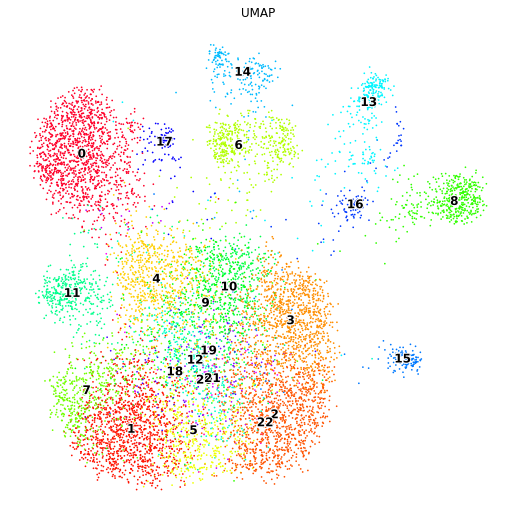

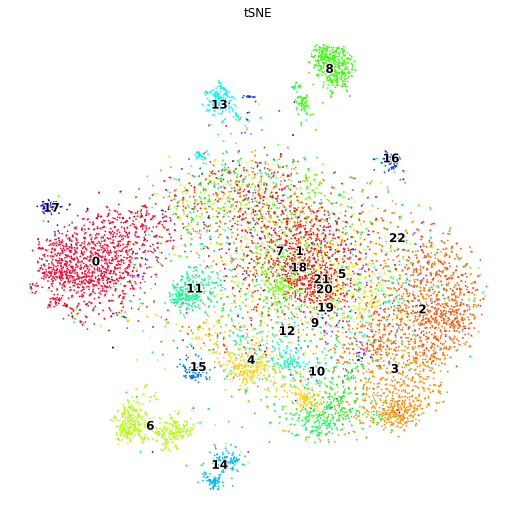

0 : 1376
1 : 1255
2 : 1120
3 : 1066
4 : 710
5 : 530
6 : 530
7 : 502
8 : 461
9 : 425
10 : 420
11 : 411
12 : 396
13 : 284
14 : 209
15 : 141
16 : 118
17 : 101
18 : 74
19 : 72
20 : 71
21 : 33
22 : 4


In [5]:
############################ High_var = True ######################################
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
scRNAseq_adrs = input_dir + 'scRNAseq.csv'
# Find marker genes of scRNAseq data

markers_rna, rna = scRNAseq_clustering_original(scRNAseq_adrs, filtering=True, resl=2.23, highly_var=True, mus=False)


AnnData object with n_obs × n_vars = 14 × 10309
AnnData object with n_obs × n_vars = 10309 × 14


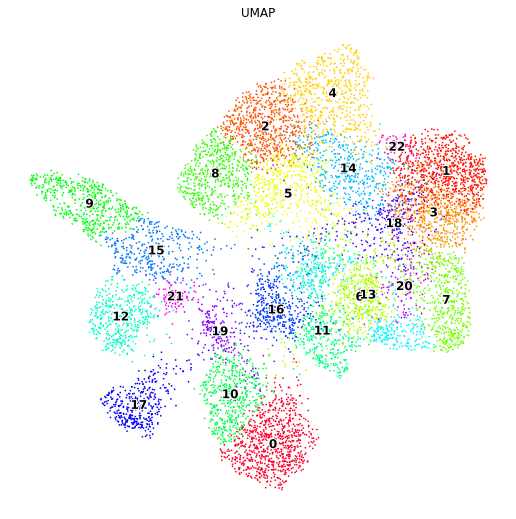

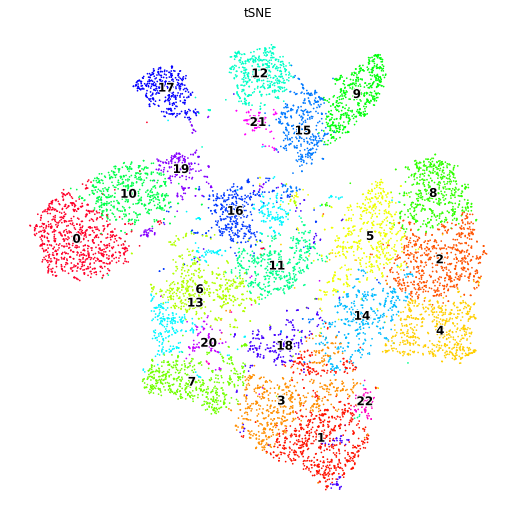

0 : 812
1 : 761
2 : 671
3 : 612
4 : 579
5 : 563
6 : 541
7 : 535
8 : 531
9 : 509
10 : 506
11 : 446
12 : 439
13 : 414
14 : 411
15 : 407
16 : 400
17 : 362
18 : 305
19 : 235
20 : 100
21 : 96
22 : 74


In [6]:
# Find clusters of low dimensional cisTopic result for scATACseq
# This is the same as when we use closest downstream genes 
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
# 1.9 > 21
atac = clustering(input_dir + 'cisTopic_topics.tsv', transpose=True, resl=2)


############################ scATAC ######################################
# 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
# Ref: http://localhost:8080/notebooks/alignment/bedtools_intersect/pipeline_preprocessing_intersect.ipynb
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
f_original = 'pred_intersect_genes.csv'
markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)


atac_cis_on_org.obs.index = [ind[1:] for ind in atac_cis_on_org.obs.index]
atac.obs.index = [ind[1:] for ind in atac.obs.index]



In [7]:
# sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=16, legend_fontoutline=4,frameon=True, title='UMAP ATACseq', palette='gist_rainbow', save='UMAP_ATAC_10k_all.svg')#
# sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=16, legend_fontoutline=4,frameon=True, title='UMAP RNAseq', palette='gist_rainbow', save='UMAP_RNA_10k_all.svg')#


## Min_cells: 200

In [8]:
rna, atac_cis_on_org,  markers_rna, markers_atac = rm_small_cluster2(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


RNA: 20
RNA: 22
RNA: 16
RNA: 17
RNA: 19
RNA: 15
RNA: 18
RNA: 21
ATAC: 20
ATAC: 22
ATAC: 21


In [9]:
len(set(rna.obs['leiden']))

15

In [10]:
# Checkpoint

pd.set_option('display.max_columns', 30)
n, m = len(set(rna.obs['leiden'])), len(set(atac_cis_on_org.obs['leiden']))
df_aggr = pd.DataFrame(np.zeros((n,m)), columns=np.arange(0,m), index=np.arange(0,n))
for my_threshold in np.arange(0.0, 1.0, 0.1):
#     print(my_threshold)
    col_ind, res = match_clusters3(markers_rna, markers_atac, method="rank_rna_shared", verbose=False, threshold=my_threshold, top_100=True, disp_res=True)
    print(my_threshold.round(1), col_ind)
    for i in range(len(col_ind)):
        df_aggr.iat[i, col_ind[i]] = df_aggr.iat[i, col_ind[i]] + 1
        
display(df_aggr)

# Linear Assignment to get final col_ind (cluster alignment)
cost = df_aggr.to_numpy(dtype='float') * -1
row_ind, col_ind = linear_sum_assignment(cost)
print(col_ind)

,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,10.5627,1.67195,3.01556,1.51271,3.01798,2.64853,7.27302,0.982256,3.06443,6.86221,10.8898,4.34217,6.45721,2.45606,1.39944,7.28434,7.72332,8.57791,2.80637,9.67497
1_rna,1.69791,3.05273,8.98176,4.01995,7.21453,9.15439,1.69845,4.08096,8.55101,2.88386,1.8064,3.00676,3.68388,3.93606,8.1275,3.12866,4.99191,4.45281,3.75877,2.07834
2_rna,2.48595,7.74482,2.814,7.99403,2.88679,4.35941,5.17147,6.39907,3.30184,3.3343,2.68648,2.01785,4.18604,3.4288,6.98464,4.63039,2.38155,2.57202,8.53242,3.17773
3_rna,1.53931,8.63664,3.55372,9.01258,3.46167,4.28489,4.51077,7.86513,3.8943,6.37621,1.72294,2.11236,7.26159,5.84522,6.52888,6.90366,2.46097,2.9856,9.48015,4.6845
4_rna,5.59752,3.21218,4.36037,4.043,4.43757,3.4085,6.82816,3.33914,2.99053,3.56151,5.00414,5.1357,6.50591,2.04539,3.24787,3.70777,4.69475,6.38388,3.99722,5.37411
5_rna,0.568773,4.56891,5.64961,4.92246,4.4769,5.85428,1.61048,3.30963,4.85428,1.50434,0.447214,0.258199,2.94253,1.10856,6.10576,2.60687,1.50315,1.15203,6.10806,1.63281
6_rna,3.32764,3.33471,3.49273,3.70202,2.78502,4.81211,2.51217,3.61862,3.73867,12.2393,5.57762,1.47732,13.949,3.23983,3.276,12.6869,2.16094,7.22363,6.85955,10.624
7_rna,2.10231,0.790612,7.00704,2.16802,5.68682,6.5982,1.8201,2.82235,7.2031,4.354,2.31916,3.73539,5.58528,3.91052,6.36152,4.38188,4.7148,5.32613,1.76619,3.1752
8_rna,2.13761,3.84768,1.63978,3.18755,2.53543,1.25735,2.06954,3.26485,1.64442,16.15,2.52084,1.04392,15.3397,2.83276,2.37688,16.1475,1.84207,3.01107,3.83732,8.58606
9_rna,0.899953,3.01878,4.80299,4.4133,4.42912,2.64793,3.90387,4.7648,2.77788,2.4837,0.931512,3.63472,3.64285,4.16862,3.85923,2.47377,2.40471,3.38387,2.90905,2.09931


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.97,0.56,0.95,0.09,1,0,0.99,1,0.62,0,0.01,0.88,0.985,0.925,0.69,0,0,1,0.13
1_rna,0.97,0.585,0,0.115,0,0,0.95,0.085,0,0.99,1,0.375,0.98,0.375,0,0.995,0.4,0.405,0.985,1
2_rna,0.72,0,0.265,0,0.045,0.825,0.005,0,0.88,0.99,1,0.38,0.985,0.055,0,0.83,0.83,0.82,0,1
3_rna,0.99,0,0.42,0,0.065,0.83,0.015,0,0.92,0.495,1,0.325,0.835,0.055,0,0.44,0.915,0.94,0,1
4_rna,0.03,0.365,0.045,0.02,0,0.96,0,0.13,0.94,1,0.94,0,0.85,0.72,0.005,1,0.03,0,0.99,0.955
5_rna,0.9,0.01,0,0,0,0.015,0.195,0,0.03,0.995,1,0.905,0.885,0.745,0,0.94,0.775,0.74,0,1
6_rna,0.815,0.755,0.72,0.33,0.7,0.995,0.87,0.565,1,0,1,0.955,0,0.835,0.36,0.01,1,0.025,0.935,0.575
7_rna,0.93,0.985,0,0.395,0,0.005,0.945,0.25,0.065,0.755,1,0.03,0.6,0.15,0,0.935,0.23,0.045,1,1
8_rna,0.975,0.995,1,0.725,0.865,1,1,0.66,1,0,1,1,0,0.985,0.665,0,1,1,1,0.98
9_rna,0.845,0.055,0,0,0,0.7,0.02,0,0.545,0.885,1,0.005,0.765,0.045,0,0.985,0.215,0.18,0.83,0.995


0.0 [10  2  1 18  6 14 12  8  9  7  3 17  5 15 19]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,9.34171,1.02778,1.32039,0.884919,2.10473,1.75692,5.74411,0.462541,2.18746,6.50536,10.0032,2.71097,5.58449,0.93283,0.578949,6.61752,6.34768,7.82125,1.8754,9.40759
1_rna,1.13555,2.84421,8.02739,2.65947,6.5449,7.6291,0.974847,3.86776,7.53685,2.28594,1.30544,2.6532,3.52375,3.43606,5.79947,2.43915,3.51178,2.9974,2.5748,2.07834
2_rna,2.01457,7.07458,1.81993,7.25324,2.21432,2.41925,3.31613,4.37413,2.87033,2.95797,2.2843,1.31,3.65088,2.03641,4.85959,3.34267,1.26051,1.73739,6.72312,2.55723
3_rna,1.03145,6.69191,2.53741,7.91431,2.04627,3.28901,4.13535,6.74482,3.28274,6.06533,1.26019,1.254,6.45087,4.86709,2.95935,6.35401,1.24375,2.69693,7.10274,3.5642
4_rna,4.89042,1.9486,2.44681,3.04315,3.85929,1.68699,4.70888,2.54512,2.29335,3.39248,4.52648,4.3008,5.21576,1.57813,2.16657,3.51879,2.59369,5.73554,2.07356,4.35939
5_rna,0.267261,4.25268,3.82085,3.8618,3.09711,4.50073,0.80971,2.66007,4.40707,0.908248,0,0.258199,2.6263,1.10856,4.10028,1.1856,0.288675,0.798472,4.21406,1.63281
6_rna,2.95213,2.54588,2.09984,2.8898,2.3364,1.84986,1.96529,2.97431,3.16722,11.3508,4.32889,0.966719,13.5636,2.6524,1.74459,12.213,1.02054,5.72072,4.98887,8.36518
7_rna,1.90986,0.790612,6.81092,1.15526,4.34354,5.89451,1.60189,2.82235,5.96056,3.79034,1.683,2.15811,5.58528,3.12555,2.06883,4.15828,2.75278,4.61902,1.37891,1.7895
8_rna,1.78925,2.27592,0.789007,2.62608,2.17486,0.530573,1.68101,2.93487,1.2176,15.7852,1.7467,0.828813,15.0143,2.37215,1.53159,15.91,0.826516,1.60772,1.87978,3.95026
9_rna,0.899953,1.33648,2.64104,3.13538,4.05115,2.42971,3.66134,4.38684,2.33366,2.26548,0.931512,2.5603,3.34134,3.85239,1.70311,2.2065,0.852465,3.03032,1.78552,1.04963


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.905,0.895,0.98,0.255,0.985,0.005,1,1,0.385,0,0.01,0.86,0.98,0.97,0.605,0,0,1,0.04
1_rna,0.975,0.11,0,0.12,0,0,0.925,0.02,0,1,1,0.17,0.99,0.06,0,1,0.355,0.605,0.93,1
2_rna,0.59,0,0.24,0,0.065,0.59,0.07,0,0.615,0.97,0.965,0.42,0.985,0.125,0,0.995,0.895,0.885,0,0.995
3_rna,0.96,0,0.47,0,0.34,0.315,0.01,0,0.735,0.45,1,0.595,0.865,0.005,0.015,0.42,0.815,0.84,0.035,1
4_rna,0.005,0.505,0.08,0.05,0,0.875,0,0.1,0.855,0.995,0.705,0,0.955,0.56,0.115,0.995,0.305,0,1,0.95
5_rna,0.915,0.005,0,0,0.005,0,0.255,0.015,0,1,NaN,0.63,0.905,0.345,0,0.995,0.92,0.725,0.005,0.99
6_rna,0.44,0.35,0.885,0.25,0.52,1,0.705,0.19,0.955,0.005,0.96,0.925,0,0.47,0.73,0.005,1,0.02,0.8,0.8
7_rna,0.815,0.73,0,0.625,0,0,0.685,0.065,0.015,0.82,1,0.06,0.21,0.1,0.035,0.905,0.61,0.01,0.995,1
8_rna,0.955,0.87,0.98,0.53,0.93,1,0.985,0.56,1,0,1,1,0,0.975,0.82,0,1,1,1,1
9_rna,0.505,0.465,0.02,0,0,0.1,0.015,0,0.46,0.88,1,0.025,0.74,0,0.08,0.965,0.67,0.105,0.83,0.995


0.1 [10  8  1  3  0  5 12  2  9  7 18 17  4 15 19]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,8.74306,0.737478,0.969825,0.702345,0.736691,0.331124,2.35355,0.158114,1.74571,5.38454,8.74839,2.0294,2.84744,0.38753,0.578949,3.63313,3.36648,6.11204,1.03919,6.97265
1_rna,1.13555,2.13011,6.92576,1.63321,4.62915,4.36945,0.208514,2.86243,6.85946,1.49988,0.327672,1.76352,2.36364,2.20021,3.40072,1.57823,1.87052,1.9974,1.49019,0.753109
2_rna,1.13587,5.82204,1.26297,5.38556,1.4018,0.66294,1.2077,2.94488,1.33,2.32506,1.02364,1.31,2.7789,0.512417,3.6499,2.13971,0.882546,0.956842,5.84452,1.81823
3_rna,0.659954,5.61826,1.95945,5.72227,0.535549,1.72375,2.66636,5.3143,2.05573,5.32841,0.164399,0.753044,5.06391,2.37801,2.36645,4.55816,0.52662,1.93059,4.6607,2.43955
4_rna,4.14047,1.31779,2.28015,2.11132,2.13842,0.383729,2.58911,1.7755,1.62875,2.45544,4.52648,2.51074,4.80419,1.418,1.72876,2.50748,1.35836,5.12029,1.33269,3.88801
5_rna,0.267261,3.47213,2.50462,2.76502,1.5659,1.73736,0,1.35856,2.24864,0.5,0,0.258199,1.54895,0.531211,3.11741,0.908248,0,0.509797,3.21224,0.447214
6_rna,2.17073,2.29121,1.64996,1.88373,1.4591,0.776866,0.776699,2.00181,2.20746,10.414,2.10091,0.590985,12.5588,1.40458,1.38111,10.0737,1.02054,4.8229,1.88428,5.87711
7_rna,1.51989,0.608037,6.14893,0.586487,3.65085,2.80331,1.18257,2.63666,5.59037,3.17949,1.2132,0.996881,4.84426,2.41844,1.32146,3.1853,2.41944,2.29575,0.403913,0.213201
8_rna,1.08904,1.809,0.364775,1.38557,1.34964,0.128037,0.411757,2.47441,0.72469,15.7852,0.950051,0.828813,14.1491,1.7322,0.711323,14.757,0.36649,1.38454,0.613266,1.93082
9_rna,0.448903,1.00315,1.70892,1.34657,2.29486,1.21501,1.62412,3.85239,2.11544,1.64774,0.455736,2.11308,2.83445,3.56372,0.835549,1.39774,0.444217,1.35481,1.00315,0.509797


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.79,0.685,0.815,0.875,0.865,0.395,1,0.825,0.615,0,0.02,0.995,0.985,0.765,0.985,0,0,0.825,0.145
1_rna,0.8,0.14,0,0.255,0,0,0.93,0.07,0,1,0.995,0.14,0.95,0.15,0,1,0.235,0.38,0.65,1
2_rna,0.545,0,0.27,0,0.445,0.43,0.265,0.02,0.88,0.98,0.99,0.105,0.99,0.615,0,0.99,0.39,0.9,0,1
3_rna,0.945,0,0.32,0,0.94,0.04,0.01,0,0.855,0.6,1,0.505,0.845,0.045,0.04,0.805,0.76,0.79,0,1
4_rna,0,0.6,0.015,0.11,0.05,0.72,0.01,0.19,0.605,1,0.025,0,0.86,0.24,0.06,0.985,0.275,0,0.745,0.765
5_rna,0.74,0,0.005,0.005,0.065,0,NaN,0.055,0.205,1,NaN,0.485,0.935,0.375,0,0.995,NaN,0.755,0,0.995
6_rna,0.31,0.045,0.74,0.305,0.74,0.735,0.945,0.52,0.8,0,0.895,0.9,0,0.75,0.46,0.04,0.69,0.005,0.675,0.855
7_rna,0.81,0.61,0,0.625,0,0,0.725,0.01,0,0.82,0.995,0.18,0.19,0.015,0.09,0.84,0.17,0.085,0.905,1
8_rna,0.645,0.59,0.975,0.885,0.99,0.98,0.995,0.54,0.975,0,0.985,0.98,0,0.72,0.87,0,1,0.995,1,1
9_rna,0.7,0.27,0.055,0.185,0.035,0.1,0.015,0,0.22,0.905,0.89,0.015,0.64,0.005,0.34,0.97,0.39,0.35,0.51,0.995


0.2 [ 0  8  1  3 10 14 12  2  9  7  6 17 18 15 19]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,7.66779,0.737478,0.683709,0.268065,0.46279,0,1.35355,0.158114,1.03885,5.25954,6.49682,0.928765,1.9526,0.158114,0.128037,1.99597,1.23486,3.62963,0,6.09709
1_rna,0.171499,1.26248,5.22849,1.27488,3.73947,2.40498,0,2.61989,5.0496,1.49988,0.171499,0.766333,1.14727,1,2.06045,0.607836,1.51387,1.42101,0.908248,0
2_rna,0.604364,4.81756,0.433524,3.97136,0.613129,0.156174,0.644038,1.59563,1.1168,1.72283,0.408248,0.325205,2.6074,0.154303,2.16108,1.63191,0,0.42723,2.69594,0.579747
3_rna,0.162221,3.20907,1.73003,3.47034,0.535549,0.418398,1.66219,4.65389,1.76706,3.90303,0,0,4.25721,1.8679,0.859716,3.7371,0,1.60306,1.60152,0.208514
4_rna,2.90157,1.31779,1.78669,1.31893,2.13842,0.179605,0.408248,0.804331,0.77956,1.55222,3.24192,1.61865,4.41618,0.804331,0.8547,1.58858,0.636163,4.48359,0.735464,3.26645
5_rna,0,2.18767,1.59638,1.80971,1.3077,0.696923,0,1.10856,1.27427,0.5,0,0,0.596089,0.288675,2.85015,0,0,0.267261,1.55151,0
6_rna,1.36618,1.64888,1.54336,1.39518,1.02191,0.222681,0.362456,1.85747,1.2596,10.0013,1.08795,0.334094,11.5428,0.98947,0.549961,8.45091,0.459664,3.7065,0.579911,2.88125
7_rna,1,0.403913,5.49543,0.218218,1.91755,2.12341,0.182574,2.13666,4.69769,3.00799,1.2132,0.242536,2.38375,1.09967,0.645949,2.61031,2.14209,1.64025,0.403913,0.213201
8_rna,0.847989,1.13185,0.249305,0.594472,0.726326,0.128037,0.286757,1.98477,0.604304,15.4309,0.621481,0.318395,12.8945,1.30914,0.48159,13.6209,0.132453,0.864386,0.105409,0.266461
9_rna,0.213201,0.714475,1.70892,0.724564,2.07125,0.408248,1.0579,3.49884,2.11544,1.42413,0,1.2357,2.27751,2.63281,0,1.17413,0.235702,1.35481,0,0.242536


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.44,0.625,0.915,0.865,NaN,0.68,0.995,0.73,0.185,0,0.285,0.995,0.935,0.88,0.935,0.075,0.075,NaN,0
1_rna,0.93,0.29,0,0.305,0,0,NaN,0.04,0,0.98,0.91,0.425,1,0.78,0.015,0.995,0.145,0.47,0.295,NaN
2_rna,0.845,0,0.8,0,0.635,0.375,0.195,0.02,0.44,0.985,0.94,0.435,0.79,0.85,0.02,0.865,NaN,0.97,0,0.97
3_rna,0.98,0,0.13,0,0.87,0.135,0.025,0,0.385,0.405,NaN,NaN,0.59,0.1,0.36,0.355,NaN,0.765,0.15,1
4_rna,0.035,0.24,0.005,0.44,0.005,0.35,0.675,0.545,0.615,0.995,0,0,0.47,0.345,0.425,0.925,0.37,0,0.25,0.085
5_rna,NaN,0.005,0.015,0.01,0.145,0.01,NaN,0.07,0.23,1,NaN,NaN,0.955,0.33,0,NaN,NaN,0.785,0,NaN
6_rna,0.56,0.04,0.28,0.295,0.685,0.685,0.835,0.21,0.805,0,0.76,0.855,0,0.65,0.775,0.005,0.775,0.11,0.435,0.39
7_rna,0.89,0.515,0,0.77,0.005,0,0.555,0.025,0,0.625,0.735,0.605,0.715,0.23,0.15,0.525,0.025,0.17,0.155,0.97
8_rna,0.785,0.43,0.985,0.91,0.975,0.9,0.985,0.32,0.89,0,0.73,1,0,0.825,0.975,0,0.965,1,0.675,0.995
9_rna,0.73,0.295,0.005,0.33,0.035,0.16,0.06,0,0.025,0.87,NaN,0.14,0.535,0,NaN,0.76,0.25,0.11,NaN,0.93


0.3 [ 0  8  1  7 19 14 12  2  9 13  6 10  3 15 17]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,6.5249,0.26412,0.33372,0.128037,0.46279,0,0,0.158114,0.320335,4.66289,5.7665,0.392638,1.16024,0.158114,0,1.15611,0.42042,2.50891,0,2.66019
1_rna,0.171499,1.06636,4.69236,0.908248,2.45197,1,0,2.27807,3.97328,1.24988,0.171499,0.188982,0.934072,1,0.855037,0.422141,0.806766,1.23532,0,0
2_rna,0.408248,4.08805,0,2.99357,0.179605,0,0.2,0.746003,0.229416,1.22728,0.408248,0,1.83136,0,1.17961,0.987964,0,0.258199,1.55768,0
3_rna,0,2.61817,0.894485,2.54234,0.27735,0.188982,0.900383,3.01905,1.46555,3.17691,0,0,2.4278,0.412589,0.447214,1.99939,0,0.833333,0.601517,0.208514
4_rna,2.65903,0.57735,1.58256,0.985599,1.7779,0,0.408248,0.804331,0.415308,1.2507,2.64583,1.18637,3.20907,0.408248,0.57735,0.668276,0.258199,3.09006,0,2.49359
5_rna,0,2.18767,1.26304,1.80971,0,0.288675,0,0.531211,0.696923,0,0,0,0.596089,0.288675,1.25,0,0,0.267261,0.551511,0
6_rna,0.81883,1.30078,0.712801,0.916647,0.876044,0,0.362456,1.50002,0.674147,8.97489,0.937191,0.216242,9.83904,0.629736,0,7.55049,0.299535,3.46826,0.109764,1.91445
7_rna,1,0.403913,3.80984,0.218218,1.44616,0.333333,0,1.30931,3.16748,2.83391,1.2132,0,2.38375,0.522316,0,1.82444,0.434986,1.24917,0,0.213201
8_rna,0.847989,1.02338,0.128037,0.486007,0.456925,0.128037,0.132453,1.81069,0.604304,15.3184,0.40691,0.318395,11.8438,1.30914,0.353553,13.2076,0,0.606188,0,0
9_rna,0.213201,0,1.45072,0.724564,1.4939,0.408248,0.724564,3.21016,0.991217,1.17413,0,1,1.45148,0.855462,0,0.731518,0.235702,0.490551,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.77,0.77,0.905,0.705,NaN,NaN,0.93,0.92,0.125,0,0.57,0.995,0.815,NaN,0.88,0.19,0.35,NaN,0.005
1_rna,0.88,0.26,0,0.48,0,0.105,NaN,0.08,0,0.975,0.75,0.585,0.975,0.66,0.04,0.97,0.105,0.495,NaN,NaN
2_rna,0.86,0,NaN,0,0.81,NaN,0.37,0.305,0.855,0.975,0.76,NaN,0.845,NaN,0.22,0.66,NaN,0.945,0.005,NaN
3_rna,NaN,0,0.125,0.01,0.86,0.145,0.025,0.005,0.16,0.52,NaN,NaN,0.66,0.45,0.455,0.295,NaN,0.895,0.03,0.61
4_rna,0.015,0.81,0,0.49,0.015,NaN,0.42,0.37,0.64,0.975,0,0.05,0.66,0.59,0.39,0.895,0.285,0.02,NaN,0
5_rna,NaN,0,0.03,0,NaN,0.045,NaN,0.14,0.255,NaN,NaN,NaN,0.92,0.27,0.035,NaN,NaN,0.68,0,NaN
6_rna,0.69,0.055,0.6,0.375,0.715,NaN,0.485,0.205,0.93,0,0.295,0.905,0,0.64,NaN,0,0.565,0.075,0.56,0.005
7_rna,0.775,0.345,0,0.655,0.025,0.12,NaN,0.055,0,0.485,0.335,NaN,0.27,0.265,NaN,0.33,0.06,0.3,NaN,0.395
8_rna,0.775,0.69,0.905,0.87,0.99,0.855,0.98,0.185,0.775,0,0.6,0.995,0,0.69,0.9,0,0.87,1,0.9,0.58
9_rna,0.58,NaN,0.015,0.205,0.06,0.04,0.025,0,0.15,0.805,NaN,0.325,0.615,0.16,NaN,0.7,0.09,0.56,NaN,NaN


0.4 [ 0  2  1  3 19 14 12  8  9  7  6 10  4 15 17]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,6.39127,0,0,0,0.329159,0,0,0.158114,0,4.05736,5.11555,0.392638,1.02893,0,0,1.01177,0.258199,2.33213,0,1.22942
1_rna,0.171499,0.908248,3.45736,0.908248,0.844286,1,0,0.735702,2.65569,0.779335,0,0.188982,0.757295,0,0.408248,0.179605,0,0.552399,0,0
2_rna,0.408248,2.79357,0,2.05768,0.179605,0,0,0.546003,0,1.06288,0,0,0.989061,0,0,0.458514,0,0.258199,0,0
3_rna,0,1.64196,0.466332,0.825124,0.27735,0.188982,0.223607,2.65329,1.1882,2.68741,0,0,1.77669,0.223607,0,1.83717,0,0.5,0,0
4_rna,2.65903,0.57735,0.441749,0.985599,1.5197,0,0.408248,0.574915,0.179605,1.05825,1.76326,0.729416,2.56017,0.408248,0,0.668276,0,2.92993,0,0.377964
5_rna,0,1.80971,1.26304,1.80971,0,0.288675,0,0,0.696923,0,0,0,0.242536,0,1,0,0,0.267261,0,0
6_rna,0.696661,0.813065,0.592415,0.214021,0.760574,0,0.104257,0.841743,0.519844,8.10914,0.59946,0.216242,8.94109,0.104257,0,6.83679,0,2.16639,0,0
7_rna,1,0.403913,2.44273,0.218218,0.223607,0.333333,0,0.708711,2.58192,2.44128,0,0,1.0725,0,0,1.15541,0,0.389977,0,0
8_rna,0.715535,0.867211,0.128037,0.353553,0.456925,0,0.132453,1.41068,0.604304,15.0939,0.232833,0.162221,11.4356,0.602037,0,12.7188,0,0.426582,0,0
9_rna,0.213201,0,0.985599,0.447214,1,0.408248,0.447214,1.22456,0.637664,1.17413,0,1,0.506766,0.447214,0,0.731518,0,0.490551,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,NaN,NaN,NaN,0.715,NaN,NaN,0.825,NaN,0.075,0,0.395,0.915,NaN,NaN,0.54,0.205,0.155,NaN,0.015
1_rna,0.795,0.27,0,0.255,0.09,0.05,NaN,0.42,0,0.94,NaN,0.48,0.905,NaN,0.19,0.925,NaN,0.64,NaN,NaN
2_rna,0.665,0,NaN,0.005,0.62,NaN,NaN,0.345,NaN,0.875,NaN,NaN,0.91,NaN,NaN,0.67,NaN,0.88,NaN,NaN
3_rna,NaN,0.06,0.395,0.085,0.79,0.085,0.175,0.01,0.085,0.455,NaN,NaN,0.57,0.5,NaN,0.175,NaN,0.945,NaN,NaN
4_rna,0.005,0.595,0.25,0.22,0.025,NaN,0.115,0.345,0.69,0.91,0.035,0.155,0.6,0.465,NaN,0.6,NaN,0.005,NaN,0.08
5_rna,NaN,0,0.005,0.005,NaN,0.005,NaN,NaN,0.11,NaN,NaN,NaN,0.88,NaN,0.06,NaN,NaN,0.52,NaN,NaN
6_rna,0.58,0.265,0.47,0.83,0.645,NaN,0.54,0.59,0.795,0,0.415,0.765,0,0.92,NaN,0,NaN,0.235,NaN,NaN
7_rna,0.625,0.215,0,0.44,0.63,0.03,NaN,0.06,0,0.42,NaN,NaN,0.66,NaN,NaN,0.325,NaN,0.74,NaN,NaN
8_rna,0.545,0.655,0.965,0.615,0.985,NaN,0.675,0.28,0.595,0,0.555,1,0,0.51,NaN,0,NaN,1,NaN,NaN
9_rna,0.41,NaN,0.095,0.315,0.33,0.015,0.04,0.02,0.125,0.605,NaN,0.22,0.92,0.235,NaN,0.465,NaN,0.395,NaN,NaN


0.5 [ 0  2  1  7 17  3 12  8  9 11  6 10  4 15 19]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,5.27568,0,0,0,0.169031,0,0,0,0,2.65971,4.80507,0.169031,0.703085,0,0,0.633809,0,0.971406,0,1
1_rna,0,0.908248,1.28868,0.408248,0.288675,0,0,0,2.31494,0.607836,0,0,0.185695,0,0,0.179605,0,0.204124,0,0
2_rna,0,2.79357,0,1.20412,0,0,0,0.353553,0,1.06288,0,0,0.989061,0,0,0.25,0,0,0,0
3_rna,0,0.447214,0.188982,0.67082,0.27735,0,0.223607,1.50806,0.958783,2.47889,0,0,1.61002,0,0,0.166667,0,0.5,0,0
4_rna,2.44583,0.57735,0,0.985599,1.18637,0,0.408248,0.408248,0,1.05825,1.76326,0.729416,2.37759,0,0,0.235702,0,1.47437,0,0
5_rna,0,1.80971,0.288675,1.55151,0,0,0,0,0.288675,0,0,0,0,0,0,0,0,0.267261,0,0
6_rna,0.477291,0.109764,0.154303,0.214021,0.760574,0,0.104257,0.47378,0.519844,7.39938,0.349254,0.216242,8.016,0,0,5.24928,0,1.81452,0,0
7_rna,1,0.218218,0.333333,0,0.223607,0,0,0,2.35251,2.44128,0,0,0.770986,0,0,1.15541,0,0.176777,0,0
8_rna,0.40691,0.353553,0.128037,0.353553,0.290258,0,0.132453,1.41068,0.243507,14.0033,0.125,0.162221,10.8387,0.498342,0,12.1874,0,0.426582,0,0
9_rna,0,0,0.408248,0.447214,1,0,0.447214,0.447214,0.637664,1.17413,0,1,0.506766,0,0,0.353553,0,0.27735,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,NaN,NaN,NaN,0.72,NaN,NaN,NaN,NaN,0.28,0,0.495,0.92,NaN,NaN,0.46,NaN,0.365,NaN,0.07
1_rna,NaN,0.09,0.095,0.275,0.46,NaN,NaN,NaN,0.005,0.88,NaN,NaN,0.935,NaN,NaN,0.775,NaN,0.82,NaN,NaN
2_rna,NaN,0,NaN,0.065,NaN,NaN,NaN,0.415,NaN,0.66,NaN,NaN,0.645,NaN,NaN,0.745,NaN,NaN,NaN,NaN
3_rna,NaN,0.385,0.38,0.135,0.5,NaN,0.05,0.085,0.095,0.19,NaN,NaN,0.26,NaN,NaN,0.875,NaN,0.875,NaN,NaN
4_rna,0.005,0.375,NaN,0.11,0.02,NaN,0.035,0.365,NaN,0.635,0,0.115,0.4,NaN,NaN,0.835,NaN,0.36,NaN,NaN
5_rna,NaN,0,0.065,0,NaN,NaN,NaN,NaN,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49,NaN,NaN
6_rna,0.65,0.875,0.84,0.59,0.37,NaN,0.29,0.66,0.48,0,0.42,0.605,0,NaN,NaN,0,NaN,0.435,NaN,NaN
7_rna,0.555,0.275,0.27,NaN,0.44,NaN,NaN,NaN,0,0.18,NaN,NaN,0.53,NaN,NaN,0.15,NaN,0.77,NaN,NaN
8_rna,0.325,0.53,1,0.73,0.995,NaN,0.275,0.21,0.95,0,0.8,0.96,0,0.425,NaN,0,NaN,1,NaN,NaN
9_rna,NaN,NaN,0.195,0.105,0.215,NaN,0.015,0.245,0.04,0.31,NaN,0.15,0.645,NaN,NaN,0.535,NaN,0.56,NaN,NaN


0.6 [10  2  1  7  4  3 12  8  9 11  6  0 13 15 17]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,4.96125,0,0,0,0.169031,0,0,0,0,1.18969,3.8522,0.169031,0.534054,0,0,0,0,0.489601,0,0
1_rna,0,0.908248,1.28868,0,0.288675,0,0,0,2.13534,0.607836,0,0,0.185695,0,0,0.179605,0,0,0,0
2_rna,0,2.15134,0,1,0,0,0,0,0,1.06288,0,0,0.989061,0,0,0.25,0,0,0,0
3_rna,0,0.447214,0.188982,0.67082,0,0,0.223607,0.223607,0.381432,2.47889,0,0,0.888566,0,0,0.166667,0,0.5,0,0
4_rna,2.08648,0.57735,0,0.408248,1.18637,0,0.408248,0.408248,0,0.881477,1.58648,0.729416,2.18148,0,0,0.235702,0,1.47437,0,0
5_rna,0,1.30151,0.288675,0,0,0,0,0,0.288675,0,0,0,0,0,0,0,0,0,0,0
6_rna,0.477291,0.109764,0,0.214021,0.216242,0,0.104257,0.354257,0.235856,7.03677,0.241421,0.216242,6.75087,0,0,4.17877,0,1.23119,0,0
7_rna,1,0.218218,0.333333,0,0,0,0,0,2.10251,2.44128,0,0,0.770986,0,0,1.15541,0,0.176777,0,0
8_rna,0.40691,0.353553,0.128037,0.353553,0,0,0,0.498342,0.128037,14.0033,0,0.162221,10.2419,0.391741,0,10.91,0,0.426582,0,0
9_rna,0,0,0.408248,0.447214,1,0,0.447214,0.447214,0.637664,0.960934,0,1,0.506766,0,0,0.353553,0,0.27735,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,NaN,NaN,NaN,0.56,NaN,NaN,NaN,NaN,0.8,0,0.345,0.825,NaN,NaN,NaN,NaN,0.505,NaN,NaN
1_rna,NaN,0.04,0.025,NaN,0.305,NaN,NaN,NaN,0,0.71,NaN,NaN,0.895,NaN,NaN,0.565,NaN,NaN,NaN,NaN
2_rna,NaN,0.005,NaN,0.11,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,0.495,NaN,NaN,0.585,NaN,NaN,NaN,NaN
3_rna,NaN,0.26,0.28,0.015,NaN,NaN,0.01,0.285,0.11,0.045,NaN,NaN,0.675,NaN,NaN,0.775,NaN,0.785,NaN,NaN
4_rna,0.01,0.155,NaN,0.11,0,NaN,0.005,0.32,NaN,0.48,0.01,0.04,0.32,NaN,NaN,0.59,NaN,0.13,NaN,NaN
5_rna,NaN,0,0.045,NaN,NaN,NaN,NaN,NaN,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,0.445,0.685,NaN,0.325,0.775,NaN,0.07,0.675,0.63,0,0.58,0.51,0,NaN,NaN,0.005,NaN,0.47,NaN,NaN
7_rna,0.445,0.165,0.2,NaN,NaN,NaN,NaN,NaN,0,0.08,NaN,NaN,0.245,NaN,NaN,0.04,NaN,0.635,NaN,NaN
8_rna,0.665,0.255,0.97,0.52,1,NaN,0.24,0.395,0.97,0,0.795,0.965,0,0.69,NaN,0,NaN,1,NaN,NaN
9_rna,NaN,NaN,0.11,0.04,0.165,NaN,0.01,0.13,0.03,0.4,NaN,0.11,0.445,NaN,NaN,0.435,NaN,0.4,NaN,NaN


0.7 [ 0  2  1  3  4  7 12  8  9 11  6 10  5 15 17]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,4.96125,0,0,0,0.169031,0,0,0,0,0.976484,1.94692,0.169031,0.362555,0,0,0,0,0.489601,0,0
1_rna,0,0.408248,0.288675,0,0,0,0,0,1.94964,0.428231,0,0,0,0,0,0,0,0,0,0
2_rna,0,1.20412,0,1,0,0,0,0,0,0.446116,0,0,0.541848,0,0,0.25,0,0,0,0
3_rna,0,0.447214,0,0.447214,0,0,0,0.223607,0.188982,2.00543,0,0,0.696116,0,0,0.166667,0,0.5,0,0
4_rna,2.08648,0.57735,0,0,0.77735,0,0,0.408248,0,0.881477,1.37796,0.729416,1.70711,0,0,0,0,1.28868,0,0
5_rna,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6_rna,0.349254,0.109764,0,0,0.114708,0,0,0.104257,0.11547,6.55411,0.241421,0.216242,6.12649,0,0,4.17877,0,1.12749,0,0
7_rna,0,0,0,0,0,0,0,0,1.89399,2.44128,0,0,0.385695,0,0,0.2,0,0,0,0
8_rna,0.232833,0,0.128037,0,0,0,0,0.498342,0,13.2962,0,0,9.60093,0.391741,0,10.6143,0,0.426582,0,0
9_rna,0,0,0,0,0,0,0,0.447214,0.408248,0.960934,0,1,0.27735,0,0,0,0,0.27735,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,NaN,NaN,NaN,0.425,NaN,NaN,NaN,NaN,0.83,0,0.25,0.865,NaN,NaN,NaN,NaN,0.33,NaN,NaN
1_rna,NaN,0.105,0.08,NaN,NaN,NaN,NaN,NaN,0.01,0.695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_rna,NaN,0.01,NaN,0.055,NaN,NaN,NaN,NaN,NaN,0.755,NaN,NaN,0.47,NaN,NaN,0.435,NaN,NaN,NaN,NaN
3_rna,NaN,0.18,NaN,0.095,NaN,NaN,NaN,0.215,0.255,0.14,NaN,NaN,0.715,NaN,NaN,0.675,NaN,0.765,NaN,NaN
4_rna,0.005,0.065,NaN,NaN,0.065,NaN,NaN,0.25,NaN,0.405,0.02,0.005,0.535,NaN,NaN,NaN,NaN,0.245,NaN,NaN
5_rna,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,0.495,0.585,NaN,NaN,0.72,NaN,NaN,0.85,0.695,0,0.395,0.295,0,NaN,NaN,0,NaN,0.39,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.035,NaN,NaN,0.54,NaN,NaN,0.57,NaN,NaN,NaN,NaN
8_rna,0.74,0.5,0.875,0.66,NaN,NaN,0.04,0.405,0.955,0,0.72,NaN,0,0.52,NaN,0,NaN,0.995,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.06,0.22,NaN,0.075,0.585,NaN,NaN,NaN,NaN,0.265,NaN,NaN


0.8 [ 0  2  3  5  4  1 12  8  9 11  7 10  6 15 17]


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,4.23016,0,0,0,0,0,0,0,0,0.740782,1.45302,0.169031,0.218218,0,0,0,0,0.149071,0,0
1_rna,0,0.408248,0,0,0,0,0,0,1.24254,0.242536,0,0,0,0,0,0,0,0,0,0
2_rna,0,1,0,0,0,0,0,0,0,0.446116,0,0,0.333333,0,0,0,0,0,0,0
3_rna,0,0.447214,0,0,0,0,0,0.223607,0.188982,1.26587,0,0,0.5,0,0,0,0,0.5,0,0
4_rna,2.08648,0.57735,0,0,0.77735,0,0,0.408248,0,0.668276,0.377964,0.5,1.70711,0,0,0,0,1,0,0
5_rna,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6_rna,0.141421,0.109764,0,0,0,0,0,0.104257,0,6.01564,0,0.114708,5.14066,0,0,3.76557,0,1.01279,0,0
7_rna,0,0,0,0,0,0,0,0,0.833333,2.23276,0,0,0.2,0,0,0.2,0,0,0,0
8_rna,0.125,0,0.128037,0,0,0,0,0.498342,0,13.1722,0,0,8.05089,0.391741,0,10.3077,0,0.208514,0,0
9_rna,0,0,0,0,0,0,0,0.447214,0.408248,0.731518,0,0,0.27735,0,0,0,0,0.27735,0,0


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83,0.005,0.17,0.905,NaN,NaN,NaN,NaN,0.75,NaN,NaN
1_rna,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,0.005,0.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_rna,NaN,0.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,0.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_rna,NaN,0.115,NaN,NaN,NaN,NaN,NaN,0.205,0.14,0.595,NaN,NaN,0.74,NaN,NaN,NaN,NaN,0.535,NaN,NaN
4_rna,0,0.095,NaN,NaN,0.055,NaN,NaN,0.21,NaN,0.455,0.06,0.105,0.375,NaN,NaN,NaN,NaN,0.495,NaN,NaN
5_rna,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_rna,0.795,0.335,NaN,NaN,NaN,NaN,NaN,0.74,NaN,0,NaN,0.415,0,NaN,NaN,0,NaN,0.325,NaN,NaN
7_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.035,NaN,NaN,0.67,NaN,NaN,0.485,NaN,NaN,NaN,NaN
8_rna,0.76,0.46,0.545,NaN,NaN,NaN,NaN,0.345,NaN,0,0.82,NaN,0,0.43,NaN,0,NaN,1,NaN,NaN
9_rna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045,0.04,0.205,NaN,NaN,0.325,NaN,NaN,NaN,NaN,0.175,NaN,NaN


0.9 [ 0  8  1 11  4  6 12  5  9  2  7 10  3 15 17]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
5,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


[ 0  2  1  3  4 14 12  8  9  7  6 10  5 15 17]


In [11]:
# Step 1
# Values of the above dataframe which are > 5 
# Which means they have been assigned together at least half of ten times


# SRR matrix for threshold 0
my_threshold = 0
col_ind_0, SRR = match_clusters3(markers_rna, markers_atac, method="rank_rna_shared", verbose=False, threshold=my_threshold, top_100=True, disp_res=True)
print(my_threshold, col_ind_0)
print("--------------------%%--------------------")

# Check values of col_ind to see if they are > 5
for row in range(len(col_ind)):
    
    if df_aggr.loc[row, col_ind[row]] < 6:
        print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Removed!")
        # Remove RNA cluster and corresponding ATAC cluster 
        # for example remove BOTH RNA cluster 2 that corresponds to  ATAC cluster 1 with value of 5.0
        # RNA
        rna = rm_cls(rna, row)
#         ATAC
        atac_cis_on_org = rm_cls(atac_cis_on_org, col_ind[row])
        
    elif df_aggr.loc[row, col_ind[row]] == 6:
        # If the value is 6 it means that the mapping is not certain
        # We need to check and see how many other clusters are bigger in that row in df_aggr matrix when thr = 0
        # Get the (sum of the absolute ditance to this cluster alignment) /  (the value for this alignment in df_aggr)

        
        # SRR value of mapped clusters in the matrix when threshold = 0
        print('$$$------------------------- Value 6 -------------------------------$$$')
        SRR_mapping = SRR.iloc[row, col_ind[row]]
        print(row, col_ind[row], SRR_mapping)
        
        # Check the row of SRR matrix for RNA cluster to get all other similarity score greater than SRR_mapping
        SRR_row = list(SRR.iloc[row,:])
        print(SRR_row)
        # Subtract the original SRR for mapped cluster from all the values
        SRR_row_diff = [diff for diff in SRR_row - SRR_mapping if diff > 0] 
        print("Diff", SRR_row_diff)
        SRR_diff_sum = np.sum(SRR_row_diff)
        print("Diff sum: ", SRR_diff_sum, "--- Diff sum / SRR mapping: ", SRR_diff_sum / SRR_mapping)
        print("-----------------------------------------------------------------")
        
        if SRR_diff_sum / SRR_mapping > 0.5:
            # Remove
            print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Removed greater than 6!")
            # RNA
            rna = rm_cls(rna, row)
    #         ATAC
            atac_cis_on_org = rm_cls(atac_cis_on_org, col_ind[row])
            
        else:
            # Keep
            print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Kept although greater than 6!")
    else:
        print(row, col_ind[row], df_aggr.loc[row, col_ind[row]], "   Kept!")

,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,10.5627,1.67195,3.01556,1.51271,3.01798,2.64853,7.27302,0.982256,3.06443,6.86221,10.8898,4.34217,6.45721,2.45606,1.39944,7.28434,7.72332,8.57791,2.80637,9.67497
1_rna,1.69791,3.05273,8.98176,4.01995,7.21453,9.15439,1.69845,4.08096,8.55101,2.88386,1.8064,3.00676,3.68388,3.93606,8.1275,3.12866,4.99191,4.45281,3.75877,2.07834
2_rna,2.48595,7.74482,2.814,7.99403,2.88679,4.35941,5.17147,6.39907,3.30184,3.3343,2.68648,2.01785,4.18604,3.4288,6.98464,4.63039,2.38155,2.57202,8.53242,3.17773
3_rna,1.53931,8.63664,3.55372,9.01258,3.46167,4.28489,4.51077,7.86513,3.8943,6.37621,1.72294,2.11236,7.26159,5.84522,6.52888,6.90366,2.46097,2.9856,9.48015,4.6845
4_rna,5.59752,3.21218,4.36037,4.043,4.43757,3.4085,6.82816,3.33914,2.99053,3.56151,5.00414,5.1357,6.50591,2.04539,3.24787,3.70777,4.69475,6.38388,3.99722,5.37411
5_rna,0.568773,4.56891,5.64961,4.92246,4.4769,5.85428,1.61048,3.30963,4.85428,1.50434,0.447214,0.258199,2.94253,1.10856,6.10576,2.60687,1.50315,1.15203,6.10806,1.63281
6_rna,3.32764,3.33471,3.49273,3.70202,2.78502,4.81211,2.51217,3.61862,3.73867,12.2393,5.57762,1.47732,13.949,3.23983,3.276,12.6869,2.16094,7.22363,6.85955,10.624
7_rna,2.10231,0.790612,7.00704,2.16802,5.68682,6.5982,1.8201,2.82235,7.2031,4.354,2.31916,3.73539,5.58528,3.91052,6.36152,4.38188,4.7148,5.32613,1.76619,3.1752
8_rna,2.13761,3.84768,1.63978,3.18755,2.53543,1.25735,2.06954,3.26485,1.64442,16.15,2.52084,1.04392,15.3397,2.83276,2.37688,16.1475,1.84207,3.01107,3.83732,8.58606
9_rna,0.899953,3.01878,4.80299,4.4133,4.42912,2.64793,3.90387,4.7648,2.77788,2.4837,0.931512,3.63472,3.64285,4.16862,3.85923,2.47377,2.40471,3.38387,2.90905,2.09931


P-values:


,0_atac,1_atac,2_atac,3_atac,4_atac,5_atac,6_atac,7_atac,8_atac,9_atac,10_atac,11_atac,12_atac,13_atac,14_atac,15_atac,16_atac,17_atac,18_atac,19_atac
0_rna,0,0.97,0.63,0.96,0.06,1,0,0.995,1,0.63,0,0.015,0.865,0.99,0.945,0.675,0,0,1,0.16
1_rna,0.975,0.57,0,0.125,0,0,0.965,0.085,0,0.995,1,0.35,0.98,0.365,0,0.995,0.32,0.41,0.94,1
2_rna,0.77,0,0.22,0,0.04,0.735,0.01,0,0.92,0.995,1,0.375,0.99,0.045,0,0.89,0.82,0.79,0,1
3_rna,0.98,0,0.5,0,0.045,0.855,0.04,0,0.96,0.56,1,0.395,0.76,0.035,0,0.465,0.92,0.945,0.01,0.995
4_rna,0.02,0.42,0.01,0.015,0,0.95,0,0.115,0.93,0.995,0.97,0,0.87,0.775,0.015,0.995,0.015,0,1,0.975
5_rna,0.96,0.005,0,0,0,0.005,0.23,0.005,0.02,0.995,1,0.845,0.93,0.775,0,0.96,0.755,0.75,0,1
6_rna,0.75,0.84,0.63,0.365,0.67,1,0.885,0.52,1,0,1,0.97,0,0.86,0.385,0.01,1,0.01,0.93,0.67
7_rna,0.905,0.975,0,0.315,0,0.01,0.915,0.235,0.02,0.81,1,0.03,0.5,0.18,0,0.98,0.315,0.035,1,1
8_rna,0.98,0.995,0.995,0.765,0.785,1,1,0.63,1,0,1,1,0,0.995,0.68,0,1,1,1,0.935
9_rna,0.83,0.04,0,0,0,0.68,0.01,0,0.585,0.91,0.995,0.005,0.81,0.04,0,0.995,0.27,0.18,0.815,0.995


0 [10  2  1 18  6 14 12  8  9  7  3 17  5 15 19]
--------------------%%--------------------
0 0 7.0    Kept!
$$$------------------------- Value 6 -------------------------------$$$
1 2 8.981757384117987
[1.6979133764549263, 3.0527270078777784, 8.981757384117987, 4.019947131875796, 7.214534047399566, 9.154386645892163, 1.698453717501293, 4.080957714648578, 8.551008643505314, 2.883859705402189, 1.8063981224898986, 3.0067564119610037, 3.683881194007349, 3.9360625957760913, 8.127504100588272, 3.128663469702481, 4.991911020997573, 4.45280667012212, 3.7587669966549564, 2.078336111363372]
Diff [0.17262926177417626]
Diff sum:  0.17262926177417626 --- Diff sum / SRR mapping:  0.01921998717972814
-----------------------------------------------------------------
1 2 6.0    Kept although greater than 6!
2 1 9.0    Kept!
3 3 4.0    Removed!


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


4 4 4.0    Removed!
5 14 4.0    Removed!
6 12 10.0    Kept!
$$$------------------------- Value 6 -------------------------------$$$
7 8 7.203095974258556
[2.1023132245310703, 0.7906115594800311, 7.0070361677862065, 2.1680159294806978, 5.68682498935229, 6.598201357151044, 1.8201043964040178, 2.822351653930805, 7.203095974258556, 4.3539989295790384, 2.3191642669544885, 3.73539380770602, 5.585281307645688, 3.9105172038891847, 6.36151785298384, 4.381883454838343, 4.7147960388201735, 5.326129835930987, 1.7661865278848345, 3.175198378341707]
Diff []
Diff sum:  0.0 --- Diff sum / SRR mapping:  0.0
-----------------------------------------------------------------
7 8 6.0    Kept although greater than 6!
8 9 10.0    Kept!
9 7 4.0    Removed!
$$$------------------------- Value 6 -------------------------------$$$
10 6 4.4245610488688865
[2.6364337139260963, 4.073046478478853, 2.127354677217247, 5.030285832613649, 2.2759754132790944, 2.8068125082439375, 4.4245610488688865, 4.1759258831000965, 2.8

In [12]:
col_ind_cor = dict()
for i in sorted(set(rna.obs['leiden'])):
    # List of corresponding clusters
    col_ind_cor[int(i)] = col_ind[int(i)] 

# Remove the clusters of ATAC that lack any correspondence in RNA
for i in set(atac_cis_on_org.obs['leiden']):
    if int(i) not in col_ind_cor.values():
        print("Removing ATAC cluster: ", i)
        atac_cis_on_org = rm_cls(atac_cis_on_org, int(i))

Removing ATAC cluster:  18
Removing ATAC cluster:  16
Removing ATAC cluster:  11
Removing ATAC cluster:  19
Removing ATAC cluster:  13


In [13]:
# Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common

# 0:0, 1:2, 2:1, 6:12, 7:8, 8:9, 10:6, 13:15

,a_0,a_1,a_12,a_15,a_2,a_6,a_8,a_9
r_0,757.0,0.0,0.0,1.0,1.0,26.0,0.0,1.0
r_1,1.0,2.0,1.0,7.0,444.0,3.0,148.0,0.0
r_10,6.0,13.0,0.0,4.0,8.0,178.0,6.0,0.0
r_13,1.0,3.0,6.0,116.0,1.0,1.0,4.0,115.0
r_2,1.0,537.0,0.0,7.0,5.0,22.0,1.0,1.0
r_6,1.0,3.0,410.0,15.0,5.0,2.0,4.0,1.0
r_7,1.0,2.0,0.0,0.0,80.0,2.0,256.0,0.0
r_8,2.0,2.0,2.0,86.0,1.0,3.0,3.0,308.0


In [14]:
df_cells_common / df_cells_common.sum().sum()

,a_0,a_1,a_12,a_15,a_2,a_6,a_8,a_9
r_0,0.209289,0.000000,0.000000,0.000276,0.000276,0.007188,0.000000,0.000276
r_1,0.000276,0.000553,0.000276,0.001935,0.122754,0.000829,0.040918,0.000000
r_10,0.001659,0.003594,0.000000,0.001106,0.002212,0.049212,0.001659,0.000000
r_13,0.000276,0.000829,0.001659,0.032071,0.000276,0.000276,0.001106,0.031794
r_2,0.000276,0.148466,0.000000,0.001935,0.001382,0.006082,0.000276,0.000276
r_6,0.000276,0.000829,0.113354,0.004147,0.001382,0.000553,0.001106,0.000276
r_7,0.000276,0.000553,0.000000,0.000000,0.022118,0.000553,0.070777,0.000000
r_8,0.000553,0.000553,0.000553,0.023777,0.000276,0.000829,0.000829,0.085153


In [14]:
df_cells_common.sum().sum()

3617.0

<span class="mark">Cluster 11 and 14 of RNA don't have high number of cells with their correspondence clusters 10 and 17 in ATAC.</span>  REMOVED! 

<span class="burk">Explained in two ways: 1) Code above 2) p-values</span>

In [15]:
print(rna.shape, atac_cis_on_org.shape)


# Number of shared cells
len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))


(5948, 4301) (4671, 21446)


3617

Trying to set attribute `.uns` of view, copying.


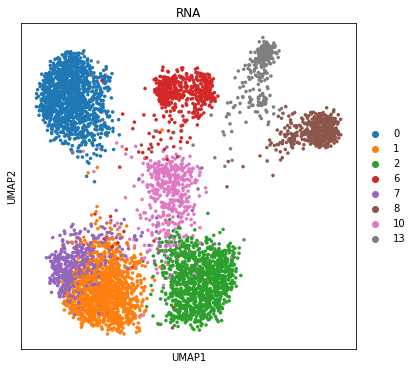

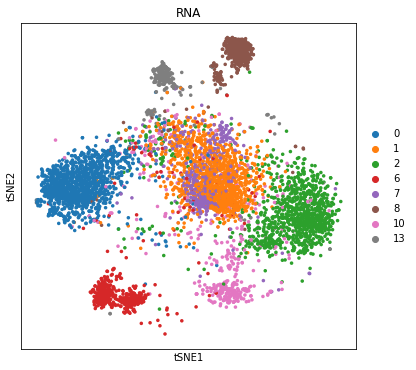

Trying to set attribute `.uns` of view, copying.


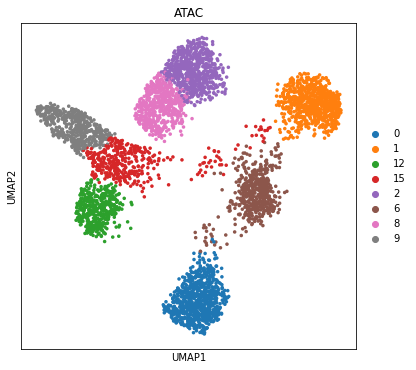

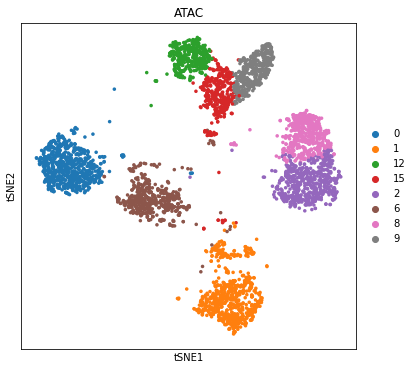

In [16]:
# Figure
rcParams['figure.figsize'] = 6, 6
rna.uns['leiden_colors']= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
sc.pl.umap(rna, color=['leiden'], size=50, title="RNA")#
sc.pl.tsne(rna, color=['leiden'], size=50, title="RNA")

# Figure
# atac.uns['leiden_colors'][-1] = '#000000'
sc.pl.umap(atac_cis_on_org, color=['leiden'], size=50, title="ATAC")#
sc.pl.tsne(atac_cis_on_org, color=['leiden'], size=50, title="ATAC")

# Colors of the clusters not necessarily show the cluster mappings


# ATAC purple, red, and brown (clusters 11, 12, 13 have no correponding cluster in RNA)
# 0:0, 1:2, 2:1, 6:12, 7:8, 8:9, 10:6, 13:15

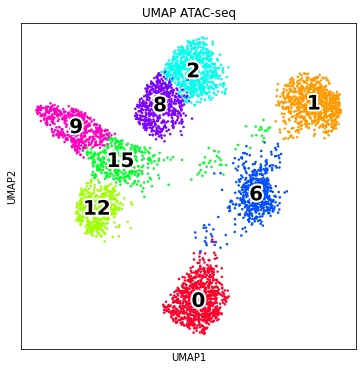

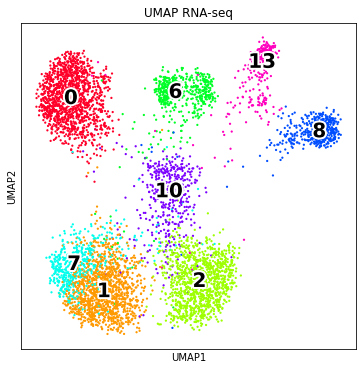

In [17]:
# Save high resolution picture
# rcParams['figure.figsize'] = 9, 9

sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=20, legend_fontoutline=4,frameon=True, title='UMAP ATAC-seq', palette='gist_rainbow', save='ATAC_10k_rm_noise_3617.svg')#
sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=20, legend_fontoutline=4,frameon=True, title='UMAP RNA-seq', palette='gist_rainbow', save='RNA_10k_rm_noise_3617.svg')#


In [18]:
print(rna.shape, atac_cis_on_org.shape)


# Number of shared cells
len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))

(5948, 4301) (4671, 21446)


3617

# FW

In [19]:
# From the above we know
# col_ind = {0:0, 1:2, 2:1, 6:12, 7:8, 8:9, 10:6, 13:15} # Removed 11:10,  14:17
col_ind = col_ind_cor

In [20]:
# Taken from Darwin
import time
from collections import Counter
from sklearn.cluster import KMeans

time1 = time.time()
# Hyperparameter 1
for my_threshold in [0]:
    print(my_threshold)
#     col_ind = match_clusters4(markers_rna, markers_atac, method="count", verbose=False, threshold=my_threshold)
    
    union_markers_rna = get_union_marker_genes(markers_rna, col_ind)
    union_mrakers_atac = get_union_marker_genes(markers_atac, col_ind)
    intersect_marker_genes = (union_markers_rna & union_mrakers_atac)
    print("Intersect: ", len(intersect_marker_genes))

    # Save cells of rna and atac clusters in two seperate dictionaries
    clusters_r = dict()
    clusters_a = dict()
    atac_k_all_genes = []
    rna_k_all_genes = []

    atac_multi_cells_clusters = dict()
    rna_multi_cells_clusters = dict()  
    
   ##################################  conserved edges ##################################
    clusters_r_intersect = dict()
    clusters_a_intersect = dict()
    clusters_r_before_multi = dict()
    clusters_a_before_multi = dict()
    intersect_marker_r_a = get_shared_markers(markers_rna, markers_atac, my_threshold)
    
    # clusters of scRNA
    for rna_k, atac_k in col_ind.items():
        # aligned cluster of scATACseq
#         atac_k = col_ind[rna_k]
        print(rna_k, atac_k)   

        # marker genes in this cluster of rna
        markers_rna_k = markers_rna[str(rna_k) + "_n"].dropna().values
        cells_in_cluster_rna = get_cells_cluster(rna, rna_k)
        # DataFrame of expression matrix for each cluster
        rna_k_all_genes.append(rna[rna.obs.loc[cells_in_cluster_rna].index, :].to_df())
        # Only marker genes
        adata_rna_k = rna[rna.obs.loc[cells_in_cluster_rna].index, markers_rna_k]
        print("RNA: ", adata_rna_k.shape)

        # marker genes in this cluster of ATAC
        markers_atac_k = markers_atac[str(atac_k) + "_n"].dropna().values
        cells_in_cluster_atac = get_cells_cluster(atac_cis_on_org, atac_k)
        # DataFrame of expression matrix for each cluster
        atac_k_all_genes.append(atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index, :].to_df())
        adata_atac_k = atac_cis_on_org[atac_cis_on_org.obs.loc[cells_in_cluster_atac].index, markers_atac_k]
        print("ATAC: ", adata_atac_k.shape)

        print("------------------------before Kmeans----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        ########################################### KMeans #################################
        if adata_rna_k.shape[0] > adata_atac_k.shape[0]:
            # Perform Kmeans on RNA data using size of ATAC data
            rna_multicell_df = find_multi_cells(adata_rna_k, n_clusters=adata_atac_k.shape[0])
            rna_multi_cells_clusters[rna_k] = rna_multicell_df # Modified 
            atac_multi_cells_clusters[col_ind[rna_k]] = adata_atac_k.to_df() # Not modified

        elif adata_rna_k.shape[0] < adata_atac_k.shape[0]:
            # Perform Kmeans on ATAC data using size of RNA data
            atac_multicell_df = find_multi_cells(adata_atac_k, n_clusters=adata_rna_k.shape[0])
            atac_multi_cells_clusters[col_ind[rna_k]] = atac_multicell_df
            rna_multi_cells_clusters[rna_k] = adata_rna_k.to_df()
        
        print("------------------------after Kmeans----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        ################# Calculate logFC for each cell based on its cluster's marker genes #################
        
        
        log2fc_rna_cluster = calc_log2fc_vectors(rna_multi_cells_clusters[rna_k], rna.to_df()[intersect_marker_genes], verbose=False)
        log2fc_atac_cluster = calc_log2fc_vectors(atac_multi_cells_clusters[col_ind[rna_k]], atac_cis_on_org.to_df()[intersect_marker_genes], verbose=False)

        clusters_r[rna_k] = log2fc_rna_cluster
        clusters_a[atac_k] = log2fc_atac_cluster
        
        # Multi cells
        log2fc_rna_cluster = calc_log2fc_vectors(rna_multi_cells_clusters[rna_k], rna.to_df()[intersect_marker_r_a[rna_k]], verbose=False)
        log2fc_atac_cluster = calc_log2fc_vectors(atac_multi_cells_clusters[col_ind[rna_k]], atac_cis_on_org.to_df()[intersect_marker_r_a[rna_k]], verbose=False)

        clusters_r_intersect[rna_k] = pd.DataFrame(log2fc_rna_cluster)
        clusters_a_intersect[atac_k] = pd.DataFrame(log2fc_atac_cluster)
        print("------------------------after multicells----------------------")
        time2 = time.time()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

    print("------------------------before similarity----------------------")  
    time2 = time.time()
    print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)
    ################################## Cell level similarities between RNA and ATAC  ##################################
    sim_all = dict()
    sim_all_non_scaled = dict()

    print_p = True

    # For each cluster
    for cls_i, cls_a in col_ind.items():
        expr_vect1_greater_dict = dict()
    #         cls_a = col_ind[cls_i]
        print(cls_i, cls_a)
        sim_df = pd.DataFrame()

        for cell1 in clusters_r[cls_i].index:
            expr_vect1 = clusters_r[cls_i].loc[cell1]
            # greater than 1 -> sort
            expr_vect1_greater = expr_vect1[expr_vect1 >= 1].sort_values(ascending=False)
    #         print(cell1, expr_vect1_greater)
            expr_vect1_greater_dict[cell1] = expr_vect1_greater
            if print_p:
                print('RNA')
#                 print(expr_vect1_greater)
                print_p = False       
        time2 = time.time()
        print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)

        print_p = True
        for cell2 in clusters_a[cls_a].index:
            expr_vect2 = clusters_a[cls_a].loc[cell2]

            # Find genes of ATAC that have avg expr >= 1 which are shared and >=1  in both RNA and ATAC
            expr_vect2_greater = expr_vect2[expr_vect2 >= 1]
            for cell1, expr_vect1_greater in expr_vect1_greater_dict.items():

                # Shared genes >= 1
                shared_genes_g_1 = set(expr_vect1_greater.index).intersection(expr_vect2_greater.index)

                genes_to_rank = expr_vect2_greater.loc[shared_genes_g_1].index

                 # Find rank RNA shared similairty
                marker_list = expr_vect1_greater.index.isin(expr_vect2_greater.index)
                indecies_in_rna = np.where(marker_list)[0]
                if True: #Top 100
                    indecies_in_rna = np.asarray([i for i in indecies_in_rna if i <= 100])
                if print_p:
                    print('ATAC')
#                     print(expr_vect2_greater)
                    print("#Genes shared and greater than 1 in RNA and ATAC: ", len(shared_genes_g_1))
                    print_p = False
                    print(indecies_in_rna)


                sim_df.loc[cell1, cell2] = np.sum(np.sqrt(1 / (indecies_in_rna + 1)))
        sim_all[cls_i] = sim_df/np.max(sim_df.to_numpy()) # scale

    print("------------------------after RNA-ATAC similarity----------------------")   
    time2 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)



    print("------------------------before similarity RNA-RNA and ATAC-ATAC ----------------------")  
    time2 = time.time()
    print("A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)   
    sim_rna_all = dict()
    sim_atac_all = dict()
    # For each cluster    
    for cls_i, cls_a in col_ind.items():
        ################################## Cell level similarities in RNA  #######################
        sim_all1, sim_all_non_scaled11 = get_similarity(cls_i, clusters_r)
        sim_rna_all[cls_i] = sim_all1
        #sim_rna_all_non_scaled.append(sim_all_non_scaled1)
        ################################## Cell level similarities in ATAC  #######################
        sim_all1, sim_all_non_scaled1 = get_similarity(col_ind[cls_i], clusters_a)
        sim_atac_all[col_ind[cls_i]] = sim_all1
        #sim_atac_all_non_scaled.append(sim_all_non_scaled1)   

    print("------------------------before FW----------------------")   
    time2 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", time2 - time1)        

    #3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 45, 50, 60, 70, 80, 90
    for n_neigh in [3]:
    #         if n_neigh < 30:
    #             levs = [1, 2, 3]
    #         elif n_neigh < 50:
    #             levs = [1, 2]
    #         else:
    #             levs = [1]
        levs = [2]
        for lev in levs:

            adj_rna = dict()
            adj_atac = dict()

            # Hyperparameter 2   
            lambds = [0.8] # 0.2, 0.8
            ind = 0
            fosccttm_df = pd.DataFrame(columns=['Cluster', 'Lambda', 'fracs1_sum', 'len_fracs1', 'fracs2_sum', 'len_fracs2'])
            n_runs = 1
            #             true_shared_E_list = []
            #             fracs_sum = pd.DataFrame(columns=['cluster', 'correspondence', 'sum_fracs', 'len'])

            fracs1_all = []
            fracs2_all = []
            
            for i, atac_i in col_ind.items():
            #                 atac_i = col_ind[i]
                ind, col = clusters_r[i].index, clusters_r[i].index
                vals = get_knn(clusters_r[i], n_neigh, level=lev)
                # Symmetric KNN
                vals = make_symm(vals, method='AND')
                adj_rna[i] = pd.DataFrame(vals, index=ind, columns=col)
                ind, col = clusters_a[atac_i].index, clusters_a[atac_i].index
                vals = get_knn(clusters_a[atac_i], n_neigh, level=lev)
                # Symmetric KNN
                vals = make_symm(vals, method='AND')
                adj_atac[atac_i] = pd.DataFrame(vals, index=ind, columns=col)



            #             for i in range(len(adj_rna)): 
                X = adj_rna[i].copy()
                Y = adj_atac[atac_i].copy()
                print(X.shape, Y.shape)

                X_mult_sim = np.multiply(X, sim_rna_all[i][0])
                Y_mult_sim = np.multiply(Y, sim_atac_all[atac_i][0])


                print("************************************ Cluster ", i, "************************************ ")
                for l in lambds:

                    for n_iter in range(n_runs):
                        final_P, col_ind_cells, frac, j_p, fracs_list1, fracs_list2 = run_fw(X_mult_sim.values, Y_mult_sim.values, sim_all[i], rna_multi_cells_clusters, i, 40, l) # gamma='opt' default
                        fracs1_all = fracs1_all + fracs_list1
                        fracs2_all = fracs2_all + fracs_list2


                        fosccttm_df.loc[0 if pd.isnull(fosccttm_df.index.max()) else fosccttm_df.index.max() + 1] = [int(i), l, np.sum(fracs_list1), len(fracs_list1), np.sum(fracs_list2), len(fracs_list2)]
            #                         fracs_sum.loc[0 if pd.isnull(fracs_sum.index.max()) else fracs_sum.index.max() + 1] = [i, col_ind[i], frac, len_fo]

            #                 np.save(str(i) + "_" + str(col_ind[i]) + str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) + "_" +  str(n_iter) +  '_fracs1.npy', fracs_list1) # save
            #                 np.save(str(i) + "_" + str(col_ind[i])  + str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) +  "_" + str(n_iter) +   '_fracs2.npy', fracs_list2) # save 
            #display(fosccttm_df)
            print(n_neigh, my_threshold)
            #             fosccttm_df.to_csv(str(n_neigh) + 'knn_marker_genes_thr_' + str(my_threshold) + '_level_' + str(lev) + '.csv', index=True, header=True, sep='\t')


0
741 268
157111 21446
Intersect:  243
0 0
RNA:  (1376, 135)
ATAC:  (812, 20111)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.22365069389343262


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (812, 135)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 17.5527822971344
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 17.87272620201111
1 2
RNA:  (1255, 102)
ATAC:  (671, 19654)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 17.907196521759033


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (671, 102)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 30.924351930618286
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 31.203330278396606
10 6
RNA:  (420, 30)
ATAC:  (541, 19226)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 31.23190140724182


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (420, 19226)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 247.20095992088318
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 247.37088656425476
13 15
RNA:  (284, 155)
ATAC:  (407, 20248)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 247.39566254615784


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (284, 20248)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 366.394407749176
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 366.5476837158203
2 1
RNA:  (1120, 109)


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


ATAC:  (761, 19443)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 366.5998115539551
After combining multi-cells:  (761, 109)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 379.8593363761902
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 380.1804118156433
6 12
RNA:  (530, 133)
ATAC:  (439, 20604)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 380.20876264572144


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (439, 133)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 386.5307352542877
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 386.73812532424927
7 8
RNA:  (502, 73)
ATAC:  (531, 19817)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 386.76803493499756


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (502, 19817)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 648.7419605255127
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 648.9840552806854
8 9
RNA:  (461, 296)
ATAC:  (509, 20703)
------------------------before Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 649.0131993293762


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


After combining multi-cells:  (461, 20703)
------------------------after Kmeans----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 896.4093070030212
------------------------after multicells----------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 896.6578447818756
------------------------before similarity----------------------
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 896.6578726768494
0 0
RNA
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 897.1390933990479
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  19
[ 0  1  2  3  6 11 12 13 14 15 16 19 21 23 28 29 39 40 42]
1 2
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 1944.7039935588837
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  10
[ 1  3  4  7  9 12 14 23 30 33]
10 6
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2647.7188787460327
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  8
[ 0  1  3  4  6  7 16 18]
13 15
A >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2926.377835035324
ATAC
#Genes shared and greater than 1 in RNA and ATAC:  19
[ 2  5  9 13 15 17 19 26 28 29 32 34 38 5

/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(812, 812) (812, 812)
************************************ Cluster  0 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


757
Check:  1376 812 0
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,1.042161e-06,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,0.000002,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,1.415049e-06,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,0.000002,0.000001,0.000002,0.000036,0.000021
09D_CGTGCTTTCAGC,0.000398,0.000192,0.000076,0.000146,0.000014,0.000041,0.000060,0.000069,0.000002,0.000037,0.000021,0.000012,0.000078,0.000013,0.000040,...,2.650221e-07,6.708256e-07,4.963014e-07,3.090799e-07,0.000006,0.000002,2.031101e-07,0.000010,1.734775e-07,6.715927e-07,0.000002,0.000001,0.000001,0.000037,0.000025
09A_CTCAATGTGTAT,0.000420,0.000192,0.000077,0.000146,0.000015,0.000043,0.000062,0.000070,0.000002,0.000038,0.000020,0.000014,0.000077,0.000012,0.000039,...,2.265863e-07,5.738516e-07,3.461533e-07,5.353340e-07,0.000005,0.000003,2.019308e-07,0.000009,1.505722e-07,6.610350e-07,0.000002,0.000002,0.000001,0.000037,0.000023
09D_ATCCGTATCCGT,0.000432,0.000196,0.000078,0.000160,0.000014,0.000045,0.000067,0.000067,0.000002,0.000036,0.000022,0.000014,0.000082,0.000014,0.000041,...,2.555277e-07,5.989903e-07,3.000129e-07,3.686669e-07,0.000005,0.000002,1.671544e-07,0.000012,1.845223e-07,5.681283e-07,0.000002,0.000002,0.000001,0.000038,0.000025


1376 812 786 0.07164965678591767 770 0.1453995589962447 0.10852460789108119


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(671, 671) (671, 671)
************************************ Cluster  1 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


444
Check:  1255 671 2
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09E_GTAGAACGTCTT,0.000402,0.000203,0.000089,0.000136,0.000017,0.000052,0.000057,0.000070,0.000003,0.000039,0.000015,0.000011,0.000070,0.000020,0.000037,...,2.399181e-07,1.046590e-06,4.020895e-07,3.188451e-07,0.000005,0.000003,1.456752e-07,0.000023,1.938306e-07,1.190725e-06,4.139157e-07,0.000001,0.000003,0.000040,0.000024
09L_CAGCAGGTAAGT,0.000419,0.000207,0.000086,0.000141,0.000018,0.000055,0.000060,0.000088,0.000002,0.000042,0.000017,0.000012,0.000072,0.000020,0.000039,...,2.545021e-07,1.411808e-06,3.249872e-07,3.203050e-07,0.000003,0.000003,1.927215e-07,0.000019,2.035072e-07,6.758684e-07,4.844118e-07,0.000001,0.000002,0.000041,0.000022
09I_TCAACCCATCCC,0.000403,0.000204,0.000089,0.000134,0.000017,0.000052,0.000058,0.000070,0.000003,0.000041,0.000015,0.000010,0.000067,0.000019,0.000040,...,2.555717e-07,7.755177e-07,2.524834e-07,2.810690e-07,0.000004,0.000003,8.245602e-08,0.000023,1.792049e-07,1.390349e-06,4.592149e-07,0.000001,0.000003,0.000037,0.000022
09F_CTAAGACGTCCC,0.000382,0.000192,0.000076,0.000124,0.000013,0.000050,0.000049,0.000065,0.000003,0.000033,0.000015,0.000012,0.000067,0.000021,0.000031,...,2.277024e-07,6.653954e-07,3.407519e-07,5.500839e-07,0.000004,0.000003,1.652996e-07,0.000024,2.434041e-07,1.077858e-06,4.726240e-07,0.000001,0.000003,0.000038,0.000023
09F_CTGGAAGTAACT,0.000380,0.000198,0.000078,0.000131,0.000016,0.000060,0.000053,0.000063,0.000003,0.000041,0.000015,0.000010,0.000073,0.000021,0.000040,...,2.207705e-07,7.557737e-07,2.676656e-07,3.197418e-07,0.000004,0.000003,8.660879e-08,0.000028,2.111647e-07,1.123278e-06,5.287135e-07,0.000001,0.000003,0.000037,0.000025


1255 671 606 0.12073092293254885 545 0.17507505472806145 0.14790298883030514


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(420, 420) (420, 420)
************************************ Cluster  10 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


178
Check:  420 541 6
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09B_GCAGAATCCAAT,0.000421,0.000198,0.000087,0.000142,0.000016,0.000040,0.000062,0.000068,0.000002,0.000038,0.000020,0.000013,0.000067,0.000013,0.000037,...,2.397144e-07,1.182497e-06,1.849627e-07,6.806820e-07,0.000004,0.000003,2.344434e-07,0.000013,1.891487e-07,9.284883e-07,7.674762e-07,0.000001,1.677541e-06,0.000038,0.000018
09C_CGAATTAGACGC,0.000458,0.000205,0.000090,0.000152,0.000019,0.000044,0.000073,0.000072,0.000003,0.000040,0.000020,0.000014,0.000072,0.000017,0.000039,...,3.513336e-07,1.312064e-06,2.285855e-07,4.702057e-07,0.000004,0.000003,1.788242e-07,0.000010,2.020917e-07,9.840675e-07,8.603707e-07,0.000002,1.304213e-06,0.000040,0.000022
09D_TATACACGTCCT,0.000445,0.000204,0.000090,0.000156,0.000017,0.000043,0.000068,0.000069,0.000002,0.000037,0.000020,0.000017,0.000076,0.000015,0.000040,...,2.497310e-07,1.228458e-06,2.180722e-07,5.894232e-07,0.000004,0.000002,2.981753e-07,0.000009,1.478267e-07,5.920350e-07,7.325389e-07,0.000001,1.107502e-06,0.000040,0.000019
09H_CTCAGCTTGGTG,0.000481,0.000209,0.000084,0.000152,0.000021,0.000048,0.000082,0.000077,0.000001,0.000045,0.000022,0.000015,0.000079,0.000012,0.000043,...,4.692938e-07,1.345883e-06,1.552451e-07,6.768650e-07,0.000003,0.000003,1.805490e-07,0.000009,2.741587e-07,8.432059e-07,9.532759e-07,0.000002,9.408416e-07,0.000045,0.000023
09I_TTCGGATTTGAA,0.000400,0.000185,0.000069,0.000143,0.000012,0.000049,0.000055,0.000058,0.000003,0.000034,0.000020,0.000012,0.000072,0.000019,0.000038,...,2.286760e-07,6.214141e-07,1.620304e-07,5.576618e-07,0.000004,0.000003,1.413841e-07,0.000014,1.968653e-07,8.070742e-07,1.283958e-06,0.000001,1.665571e-06,0.000029,0.000021


420 541 215 0.082090442317995 237 0.1732207555182103 0.12765559891810266


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(284, 284) (284, 284)
************************************ Cluster  13 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


116
Check:  284 407 15
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09K_TCCGCGAGGCCC,0.000456,0.000208,0.000097,0.000178,0.000018,0.000049,0.000067,0.000063,0.000002,0.000038,0.000023,0.000016,0.000087,0.000013,0.000041,...,2.553066e-07,0.000002,4.452457e-07,4.267688e-07,0.000005,0.000002,2.654319e-07,0.000013,1.623604e-07,6.898814e-07,6.308147e-07,0.000002,0.000002,0.000037,0.000023
09K_CGTACCAAATCG,0.000447,0.000213,0.000099,0.000158,0.000021,0.000046,0.000069,0.000082,0.000002,0.000042,0.000021,0.000014,0.000070,0.000015,0.000039,...,3.668669e-07,0.000003,3.509024e-07,3.939282e-07,0.000003,0.000002,3.277519e-07,0.000011,2.112794e-07,8.388571e-07,6.643569e-07,0.000001,0.000001,0.000043,0.000019
09B_ATTGGGTTTGCC,0.000481,0.000215,0.000097,0.000176,0.000020,0.000061,0.000071,0.000083,0.000001,0.000044,0.000021,0.000017,0.000089,0.000015,0.000041,...,3.239264e-07,0.000002,4.543642e-07,3.284798e-07,0.000004,0.000003,2.386050e-07,0.000014,1.682815e-07,7.500134e-07,2.864895e-07,0.000002,0.000002,0.000040,0.000027


284 407 247 0.1634242488813126 236 0.5833230501215838 0.3733736495014482


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(761, 761) (761, 761)
************************************ Cluster  2 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


537
Check:  1120 761 1
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09I_GAAACGCGACAG,0.000489,0.000201,0.000082,0.000165,0.000015,0.000058,0.000072,0.000075,0.000003,0.000034,0.000020,0.000017,0.000083,0.000025,0.000037,...,3.341400e-07,7.233043e-07,1.891131e-07,4.118847e-07,0.000004,0.000003,9.661632e-08,0.000009,1.803657e-07,8.243312e-07,3.519699e-07,0.000003,1.295046e-06,0.000033,0.000026
09L_TACGCTCCTCCT,0.000434,0.000196,0.000081,0.000138,0.000016,0.000051,0.000061,0.000085,0.000003,0.000038,0.000018,0.000013,0.000065,0.000024,0.000034,...,2.493027e-07,1.288293e-06,2.501331e-07,4.616656e-07,0.000003,0.000003,1.804938e-07,0.000010,1.718493e-07,7.922422e-07,5.332997e-07,0.000002,1.507710e-06,0.000034,0.000021
09D_AGCCCGTAATTA,0.000430,0.000193,0.000078,0.000129,0.000017,0.000047,0.000065,0.000074,0.000004,0.000038,0.000017,0.000012,0.000061,0.000026,0.000035,...,2.639806e-07,1.006065e-06,1.289517e-07,5.257337e-07,0.000003,0.000003,1.405675e-07,0.000010,1.778895e-07,9.347093e-07,6.196037e-07,0.000002,1.282199e-06,0.000036,0.000021
09B_CGGAGGTGGAAT,0.000439,0.000190,0.000068,0.000129,0.000016,0.000053,0.000067,0.000078,0.000004,0.000038,0.000018,0.000014,0.000067,0.000028,0.000036,...,3.067988e-07,7.212088e-07,1.302421e-07,5.967108e-07,0.000003,0.000004,1.173799e-07,0.000009,2.060277e-07,6.789775e-07,6.958163e-07,0.000002,9.625121e-07,0.000035,0.000023
09I_ATTTGACACCGG,0.000419,0.000198,0.000075,0.000123,0.000018,0.000051,0.000069,0.000082,0.000005,0.000040,0.000014,0.000012,0.000062,0.000032,0.000038,...,3.606123e-07,9.421181e-07,1.515319e-07,2.048038e-07,0.000003,0.000002,1.411288e-07,0.000014,2.082687e-07,8.928698e-07,1.064041e-06,0.000002,1.155529e-06,0.000043,0.000024


1120 761 574 0.07410259850514622 562 0.14669813161844147 0.11040036506179385


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(439, 439) (439, 439)
************************************ Cluster  6 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


410
Check:  530 439 12
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09B_GGCGCCGGGAGC,0.000568,0.000242,0.000108,0.000182,0.000027,0.000068,0.000098,0.000084,9.621692e-07,0.000051,0.000021,0.000020,0.000089,0.000008,0.000043,...,1.329566e-06,0.000005,4.141069e-07,5.248604e-07,0.000003,0.000001,4.492933e-07,0.000007,5.267127e-07,0.000002,3.937549e-07,0.000002,9.134546e-07,0.000050,0.000027
09G_ATGTTGGTTAAA,0.000474,0.000216,0.000082,0.000145,0.000021,0.000062,0.000080,0.000075,2.463121e-06,0.000044,0.000017,0.000015,0.000074,0.000017,0.000038,...,1.020572e-06,0.000003,2.755884e-07,4.542648e-07,0.000003,0.000001,3.238882e-07,0.000015,4.887283e-07,0.000002,1.236103e-06,0.000002,1.177337e-06,0.000048,0.000026
09B_GGCGGCAGAGGT,0.000558,0.000237,0.000094,0.000157,0.000029,0.000070,0.000103,0.000088,1.628957e-06,0.000057,0.000018,0.000017,0.000085,0.000013,0.000048,...,1.250467e-06,0.000004,2.308280e-07,5.644560e-07,0.000003,0.000002,2.607886e-07,0.000009,5.111066e-07,0.000002,4.438527e-07,0.000002,1.087857e-06,0.000053,0.000028
09K_ATAACGGCAGCT,0.000506,0.000214,0.000076,0.000140,0.000017,0.000063,0.000078,0.000072,1.642459e-06,0.000035,0.000018,0.000015,0.000077,0.000015,0.000032,...,1.401028e-06,0.000003,4.697078e-07,7.841232e-07,0.000005,0.000002,2.601260e-07,0.000011,6.691763e-07,0.000003,9.244640e-07,0.000002,1.164162e-06,0.000040,0.000028
09F_AGAGTTCCGAAT,0.000468,0.000209,0.000078,0.000141,0.000017,0.000061,0.000071,0.000062,2.092249e-06,0.000038,0.000018,0.000015,0.000079,0.000017,0.000037,...,9.825498e-07,0.000002,3.719220e-07,7.223467e-07,0.000005,0.000002,2.428705e-07,0.000013,4.711225e-07,0.000002,6.578394e-07,0.000002,1.712900e-06,0.000038,0.000026


530 439 441 0.05215686409085242 419 0.08348223457357062 0.06781954933221152


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(502, 502) (502, 502)
************************************ Cluster  7 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


256
Check:  502 531 8
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,1.704418e-06,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,1.272650e-06,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026
09D_CAGAAACTCAAA,0.000458,0.000215,0.000095,0.000161,0.000020,0.000052,0.000070,0.000082,1.171950e-06,0.000041,0.000020,0.000014,0.000091,0.000016,0.000042,...,2.619192e-07,8.959551e-07,6.885701e-07,3.087279e-07,0.000006,0.000003,1.328113e-07,0.000016,1.724373e-07,6.100971e-07,4.438624e-07,0.000002,0.000003,0.000044,0.000029
09H_GTAAGTGGTAGA,0.000462,0.000224,0.000104,0.000166,0.000024,0.000057,0.000071,0.000093,7.332268e-07,0.000049,0.000020,0.000014,0.000086,0.000012,0.000044,...,2.703622e-07,2.130653e-06,5.669889e-07,2.793108e-07,0.000004,0.000003,2.490363e-07,0.000017,1.643185e-07,5.729571e-07,1.573093e-07,0.000001,0.000003,0.000047,0.000025
09J_TCGAAAACCTCG,0.000443,0.000216,0.000098,0.000151,0.000022,0.000051,0.000066,0.000088,1.137906e-06,0.000044,0.000019,0.000015,0.000083,0.000015,0.000038,...,3.196540e-07,1.857387e-06,7.682394e-07,3.670811e-07,0.000006,0.000002,2.872065e-07,0.000015,1.798434e-07,7.498480e-07,4.964843e-07,0.000001,0.000002,0.000047,0.000028
09E_ACCGTACCTAGA,0.000424,0.000205,0.000085,0.000139,0.000017,0.000058,0.000057,0.000085,1.896756e-06,0.000039,0.000016,0.000013,0.000079,0.000020,0.000036,...,2.255009e-07,6.767523e-07,5.027393e-07,3.898174e-07,0.000005,0.000003,1.286907e-07,0.000020,1.791946e-07,8.584400e-07,1.795448e-07,0.000002,0.000003,0.000039,0.000026


502 531 341 0.08448939894450505 422 0.1979358007651948 0.1412125998548499


/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/ejafari/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass mode=connectivity, metric=minkowski as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(461, 461) (461, 461)
************************************ Cluster  8 ************************************ 
Inside calc_foscttm: 


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09F_GGATGAAGAGGG,0.000461,0.000211,0.000098,0.000177,0.000019,0.000050,0.000072,0.000068,0.000002,0.000039,0.000022,0.000016,0.000082,0.000014,0.000041,...,2.713964e-07,0.000002,2.571078e-07,3.184184e-07,0.000004,0.000002,2.861348e-07,0.000014,1.701774e-07,6.640747e-07,7.663685e-07,0.000002,0.000001,0.000041,0.000022
09F_GTAAAGCCAACA,0.000416,0.000196,0.000080,0.000150,0.000015,0.000046,0.000064,0.000070,0.000002,0.000040,0.000020,0.000013,0.000074,0.000013,0.000042,...,2.896389e-07,0.000001,2.050154e-07,3.834313e-07,0.000004,0.000002,2.162669e-07,0.000011,1.725882e-07,8.300145e-07,1.851467e-06,0.000001,0.000001,0.000036,0.000022
09A_GTAGGAAGCCAC,0.000409,0.000197,0.000082,0.000149,0.000015,0.000046,0.000060,0.000074,0.000002,0.000041,0.000019,0.000012,0.000071,0.000011,0.000040,...,3.170497e-07,0.000001,2.587518e-07,3.605912e-07,0.000004,0.000002,2.668798e-07,0.000011,1.766951e-07,9.555364e-07,1.922796e-06,0.000001,0.000002,0.000036,0.000021
09G_AGCGGTCGGAGC,0.000470,0.000218,0.000100,0.000172,0.000023,0.000058,0.000077,0.000077,0.000002,0.000047,0.000019,0.000016,0.000081,0.000016,0.000044,...,3.035300e-07,0.000002,1.873455e-07,1.934962e-07,0.000003,0.000002,2.616096e-07,0.000017,1.596226e-07,7.953618e-07,5.444577e-07,0.000002,0.000002,0.000046,0.000024
09I_ATAGACAGTACA,0.000425,0.000210,0.000089,0.000147,0.000018,0.000057,0.000059,0.000084,0.000002,0.000041,0.000018,0.000013,0.000080,0.000019,0.000039,...,2.794118e-07,0.000001,5.337877e-07,3.240125e-07,0.000005,0.000003,1.650474e-07,0.000020,2.093617e-07,8.156271e-07,2.697881e-07,0.000001,0.000003,0.000041,0.000026


308
Check:  461 509 9
Inside calc_foscttm, adata_atac_k: 


/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,+,-,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,...,n-R5s47,n-R5s48,n-R5s51,n-R5s58,n-R5s61,n-R5s67,n-R5s77,n-R5s79,n-R5s8,n-R5s84,n-R5s88,n-R5s95,n-R5s96,n-TSaga9,n-TStga1
09I_CTGTACGGTCCG,0.000537,0.000232,0.000122,0.000225,0.000025,0.000063,0.000084,0.000087,8.918597e-07,0.000048,0.000026,0.000023,0.000097,0.000007,0.000044,...,3.457187e-07,0.000004,3.486036e-07,1.507231e-07,0.000002,0.000001,5.428510e-07,0.000006,9.245672e-08,4.007945e-07,3.969857e-07,0.000002,1.009456e-06,0.000044,0.000023
09J_AATGGACTACTT,0.000467,0.000216,0.000110,0.000187,0.000020,0.000050,0.000066,0.000082,1.573375e-06,0.000040,0.000023,0.000017,0.000077,0.000012,0.000037,...,2.940609e-07,0.000004,3.589480e-07,3.208125e-07,0.000003,0.000002,4.845307e-07,0.000008,1.474606e-07,6.194435e-07,5.143197e-07,0.000001,1.158026e-06,0.000039,0.000018
09A_GGGCTAATCAGA,0.000470,0.000218,0.000107,0.000183,0.000022,0.000054,0.000072,0.000080,2.031417e-06,0.000044,0.000022,0.000017,0.000080,0.000015,0.000042,...,3.082532e-07,0.000003,3.269908e-07,2.611466e-07,0.000003,0.000002,4.223769e-07,0.000010,1.356013e-07,5.916448e-07,4.739757e-07,0.000001,1.304884e-06,0.000042,0.000021
09F_ATCAGCGCCACG,0.000477,0.000218,0.000106,0.000184,0.000022,0.000053,0.000072,0.000082,1.486577e-06,0.000045,0.000023,0.000018,0.000080,0.000011,0.000040,...,3.030781e-07,0.000003,2.840336e-07,3.897884e-07,0.000002,0.000002,4.607297e-07,0.000008,1.388755e-07,5.335993e-07,4.856962e-07,0.000002,1.108787e-06,0.000042,0.000020
09C_CCGAGGCTACCC,0.000514,0.000221,0.000113,0.000209,0.000022,0.000056,0.000077,0.000081,1.124833e-06,0.000042,0.000026,0.000021,0.000092,0.000009,0.000040,...,3.379773e-07,0.000004,4.225847e-07,2.748048e-07,0.000003,0.000002,4.762383e-07,0.000005,1.183815e-07,5.248385e-07,6.562427e-07,0.000002,9.514874e-07,0.000040,0.000023


461 509 407 0.0676017901509746 426 0.38248233153381384 0.22504206084239423
3 0


<div class="mark">
executed in 1h 55m 13s, finished 00:32:36 2021-04-26</div><i class="fa fa-lightbulb-o "></i>

In [21]:
fosccttm_df

,Cluster,Lambda,fracs1_sum,len_fracs1,fracs2_sum,len_fracs2
0,0.0,0.8,334915.000000,786.0,522842.274195,770.0
1,1.0,0.8,435100.000000,606.0,445592.275541,545.0
2,10.0,0.8,104961.250000,215.0,191719.000000,237.0
3,13.0,0.8,240055.350000,247.0,642892.000000,236.0
4,2.0,0.8,252955.000000,574.0,385015.114358,562.0
5,6.0,0.8,136788.000000,441.0,163352.192857,419.0
6,7.0,0.8,171338.333333,341.0,390080.000000,422.0
7,8.0,0.8,163625.333333,407.0,760918.000000,426.0


In [22]:
# X on Y
# (fosccttm_df['fracs1_sum'].sum() / (fosccttm_df['len_fracs1'].sum() - 1)) / fosccttm_df['len_fracs1'].sum()
fosccttm_df['fracs1_sum'].sum() / (fosccttm_df['len_fracs1'].sum() * (len(atac_cis_on_org) - 1))

0.10891574149117784

In [23]:
# X on Y
# (fosccttm_df['fracs1_sum'].sum() / (fosccttm_df['len_fracs1'].sum() - 1)) / fosccttm_df['len_fracs1'].sum()
fosccttm_df['fracs2_sum'].sum() / (fosccttm_df['len_fracs2'].sum() * (len(rna) - 1))

0.16282483367389403

In [25]:
fracs1_all = [i / (len(atac_cis_on_org) - 1) for i in fracs1_all]
fracs2_all = [i / (len(rna) - 1) for i in fracs2_all]

In [26]:
# Save fracs_all1 and fracs_all2

print(len(fracs1_all), len(fracs2_all))

import pickle
out_dir = "/home/ejafari/alignment/downstream/notebooks/SNAREseq_Mus/rm_noise/10k/FW_res/"

with open(out_dir + 'fracs1_3617.pickle', 'wb') as handle:
    pickle.dump(fracs1_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(out_dir + 'fracs2_3617.pickle', 'wb') as handle:
    pickle.dump(fracs2_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

3617 3617


# Files required for other alignment methods

## RNA

/home/ejafari/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


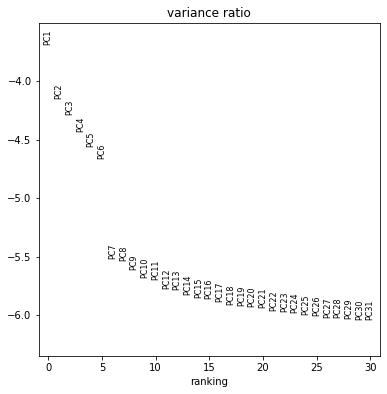

In [35]:
# Find out how many PCAs can represent the data the best
sc.tl.pca(rna, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna, log=True)

In [36]:
out_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline/"
from sklearn.decomposition import PCA
pca = PCA(n_components=22)
principalComponents_rna = pca.fit_transform(rna.to_df().values)

np.save(out_dir + 'rna_22D_pca_3617.npy', principalComponents_rna) # save

## ATAC


<span class="mark">Following MMD-MA pipeline for creating their input files</span>

In [37]:
# Read full ATAC (RAW)
ATAC_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
atac_raw = sc.read(ATAC_dir + 'scATACseq.csv').to_df()
print(atac_raw.shape)

# Remove the cells that we labeld them as noise in the previous sections
atac_raw = atac_raw[atac_cis_on_org.obs.index]
print(atac_raw.shape)

# Save ATAC file to preprocess and reduce the dimensionality of the data using MMD-MA script on the Hulk
atac_raw.to_csv(out_dir + 'ATAC_raw_3617.csv', index=True, header=True)

(244544, 10309)
(244544, 4671)


In [ ]:
# Move to the Hulk and run MMDMA's script on it.
scp ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline/ATAC_raw_3617.csv .

In [ ]:
# Bring the reduced size data back 
# scp Mus_10k_3617_chromatin_reduced_SCOT.tsv ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline 
# scp mmdma_prep_atac.R ejafari@ampere.luddy.indiana.edu:/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline/

## Similarity matrix

In [13]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

rna_feat = rna.to_df()
input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline/"
atac_feat = pd.read_csv(input_dir + "Mus_10k_3617_chromatin_reduced_SCOT.tsv", index_col=0, delimiter='\t')

rna_mat = cosine_similarity(rna_feat, rna_feat)
atac_mat = cosine_similarity(atac_feat, atac_feat)

print("Dimensions of input datasets are: ", "X= ", rna_feat.shape, rna_mat.shape, " y= ", atac_feat.shape, atac_mat.shape)


# Save atac_mat and rna_mat as npy
np.save(input_dir + "ATAC_3617_mat.npy", atac_mat)
np.save(input_dir + "RNA_3617_mat.npy", rna_mat)



Dimensions of input datasets are:  X=  (5948, 4301) (5948, 5948)  y=  (4671, 25) (4671, 4671)


## Index

In [14]:
import pickle
out_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/rm_noise/10k/baseline/FW_denoise/"

# Save RNA indecies and its markers
with open(out_dir + 'RNA_index_3617.pickle', 'wb') as handle:
    pickle.dump(rna.obs.index, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(out_dir + 'markers_RNA.pickle', 'wb') as handle:
#     pickle.dump(markers_rna, handle, protocol=pickle.HIGHEST_PROTOCOL)    


# Save ATAC indecies and its markers
with open(out_dir + 'ATAC_index_3617.pickle', 'wb') as handle:
    pickle.dump(atac_cis_on_org.obs.index, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(out_dir + 'markers_ATAC.pickle', 'wb') as handle:
#     pickle.dump(markers_atac, handle, protocol=pickle.HIGHEST_PROTOCOL)    